# ICAPS CODE


### Settings for Learning Curve plotting

In [19]:
# Settings:

# env_name        = "Measurement Regret Environment (c=0.1)"
# fileName_env    = "Loss_01"
# has_ideal_line  = True
# ideal_value     = 0.875

# env_name        = "Measurement Regret Environment (c=0.2)"
# fileName_env    = "Loss_02"
# has_ideal_line  = True
# ideal_value     = 0.8

# env_name        = "Measurement Regret Environment (c=0.05)"
# fileName_env    = "Loss_005"
# has_ideal_line  = True
# ideal_value     = 0.938

env_name        = "4x4 Frozen Lake Environment (semi-slippery)"
fileName_env    = "Lake_standard4_semi-slippery"
has_ideal_line  = False

# env_name        = "4x4 Frozen Lake Environment (slippery)"
# fileName_env    = "Lake_standard4_slippery"
# has_ideal_line  = False

# env_name        = "4x4 Frozen Lake Environment (deterministic)"
# fileName_env    = "Lake_standard4_det"
# has_ideal_line  = False

# env_name        = "8x8 Frozen Lake Environment (semi-slippery)"
# fileName_env    = "Lake_standard8_semi-slippery"
# has_ideal_line  = False

# env_name        = "12x12 Frozen Lake Environment (semi-slippery)"
# fileName_env    = "Lake_random12_semi-slippery"
# has_ideal_line  = False

# env_name        = "16x16 Frozen Lake Environment (semi-slippery)"
# fileName_env    = "Lake_random16_semi-slippery"
# has_ideal_line  = False

# env_name        = "20x20 Frozen Lake Environment (semi-slippery)"
# fileName_env    = "Lake_random20_semi-slippery"
# has_ideal_line  = False


# Algorithm details (with or without OTP alg)
# fileName_alg    = ["BAM_QMDP", "BAM_QMDP+", "AMRL", "ACNO_OTP"]
# legend_alg      = ["ATMQ",  "Dyna-ATMQ", "AMRL-Q","ACNO-OTP" ]

fileName_alg    = ["BAM_QMDP", "BAM_QMDP+", "AMRL"]
legend_alg      = ["ATMQ",  "Dyna-ATMQ", "AMRL-Q" ]

import numpy as np
# Plotting variables
plot_std        = True     # Set wether or not to plot standard deviation (turned off to increase readability)
max_eps         = np.inf    # Set manually according to restrict what episodes to plot (i.e. ignore graph after convergence)
interval        = 0.95      # Determines plotted confidence interval (currently turned off completely)
w1, w2          = 50,1      # Determine smooting window and order

# Filename details (should stay constant!)
Data_path       = "Data/Run2/"
fileName_begin  = "AMData"
fileName_end    = ".json"

### Code for learning curve plotting (Ugly, should not need to be eddited!)

In [20]:
# creating names:
Files_to_read = []
nmbr_files = len(fileName_alg)

for i in range(nmbr_files):
    Files_to_read.append("{}_{}_{}{}".format(fileName_begin,fileName_alg[i],fileName_env,fileName_end))
    
nmbr_files      = len(Files_to_read)

# Imports
import json
import math as m
import matplotlib
import matplotlib.pyplot as plt
import datetime
from scipy.signal import savgol_filter
import scipy.stats as sts
import warnings
import seaborn as sns
timestamp = datetime.datetime.now().strftime("%d%m%Y%H%M%S")

# Plot Naming

Plot_names_title    = ["Scalarized Return", "Average steps", "Average measurements"]
Plot_Y_Label        = ["Scalarized Return", "Steps", "Measurements"]
Plot_names_file     = ["Reward", "Steps", "Measures"]

nmbr_plots          = len(Plot_names_title)

In [21]:
# Data to obtain:

nmbr_steps      = []
measure_cost    = []

avg_reward,std_reward, min_reward, max_reward = [], [], [], []
avg_cum_reward      = []

avg_steps, std_steps, min_steps, max_steps = [], [], [], []
avg_measures, std_measures, min_measures, max_measures = [], [], [], []
avg_reward_noCost   = []

std_reward_test = []

nmbr_eps = []
nmbr_runs = []
measure_cost = []
# Read data:

for file_name in Files_to_read:
    with open(Data_path + file_name) as file:
        contentDict = json.load(file)
        
        avg_reward.append       ( np.average  (contentDict["reward_per_eps"]      , axis=0) )
        std_reward.append       ( np.std ( contentDict["reward_per_eps"], axis=0) ) 
        
        avg_steps.append        (np.average (contentDict["steps_per_eps"]       , axis=0)) 
        std_steps.append       ( np.std ( contentDict["steps_per_eps"] , axis=0) )
        avg_measures.append     (np.average (contentDict["measurements_per_eps"], axis=0)) 
        std_measures.append       ( np.std ( contentDict["measurements_per_eps"], axis=0))

        nmbr_eps.append     (int(contentDict["parameters"]["nmbr_eps"]))
        nmbr_runs.append    (int(contentDict["parameters"]["nmbr_runs"]))
        measure_cost.append (float(contentDict["parameters"]["m_cost"]))

all_data = [(avg_reward, std_reward), (avg_steps,std_steps), (avg_measures,std_measures)]
eps_to_plot = min(np.min(nmbr_eps), max_eps)

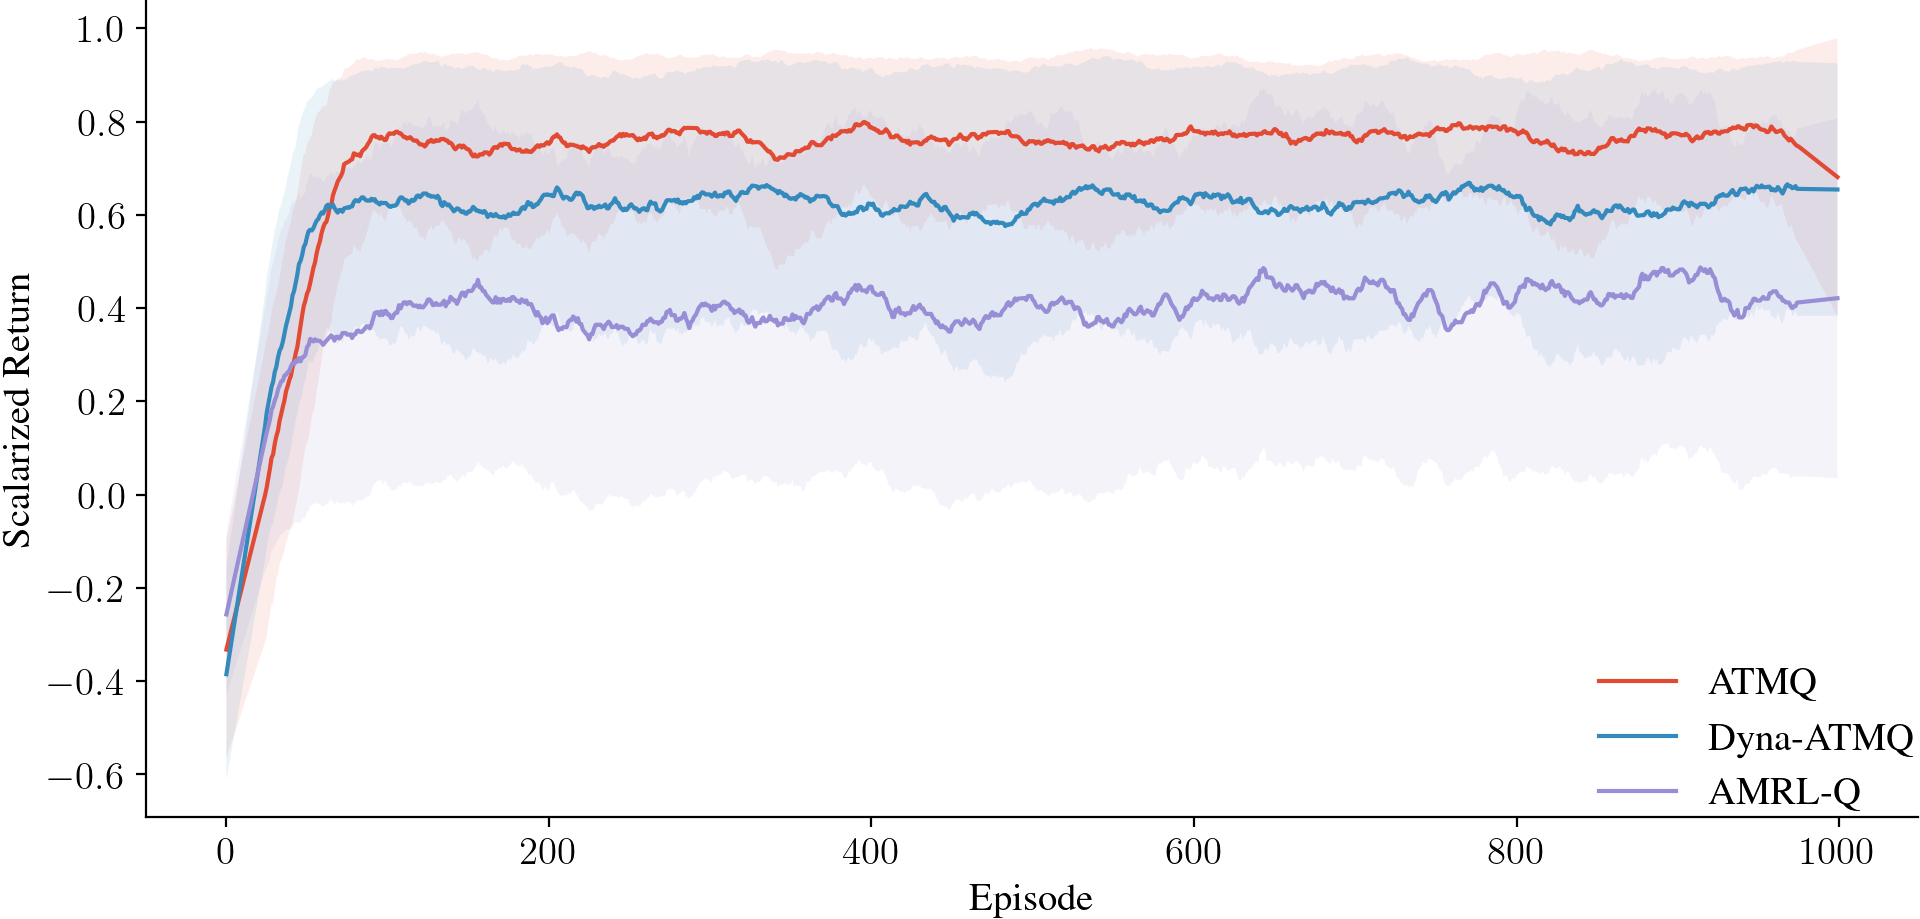

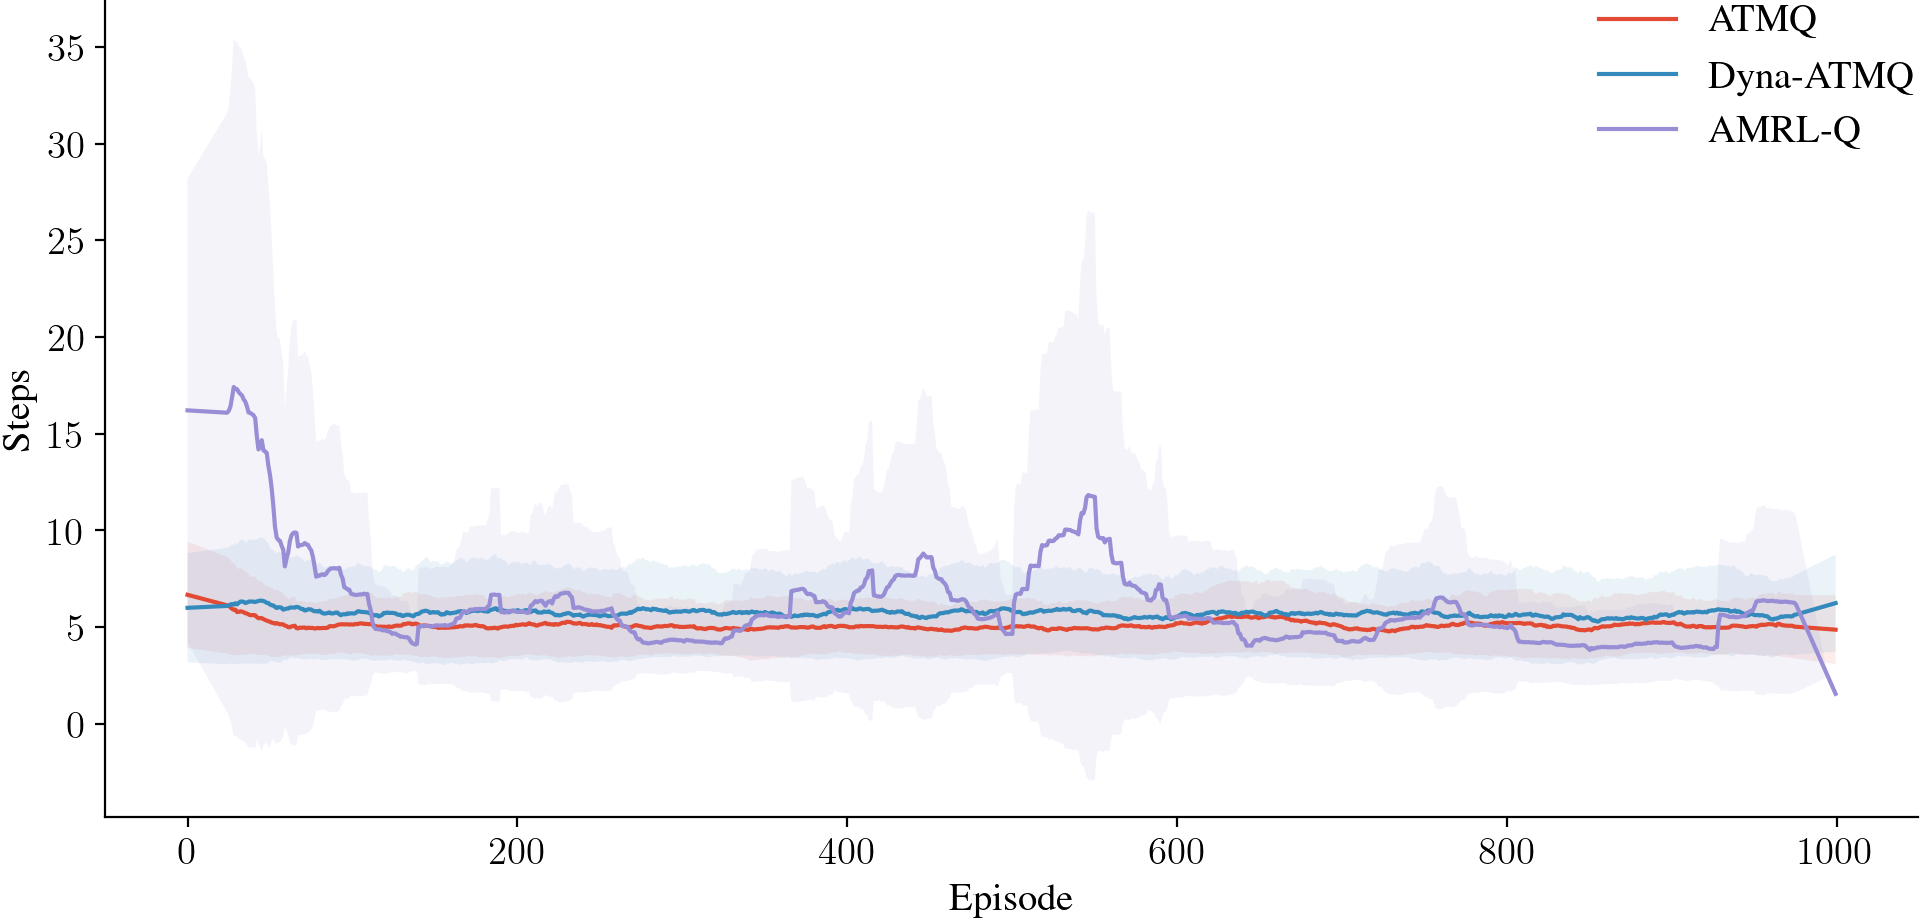

c:\Users\merli\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\merli\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


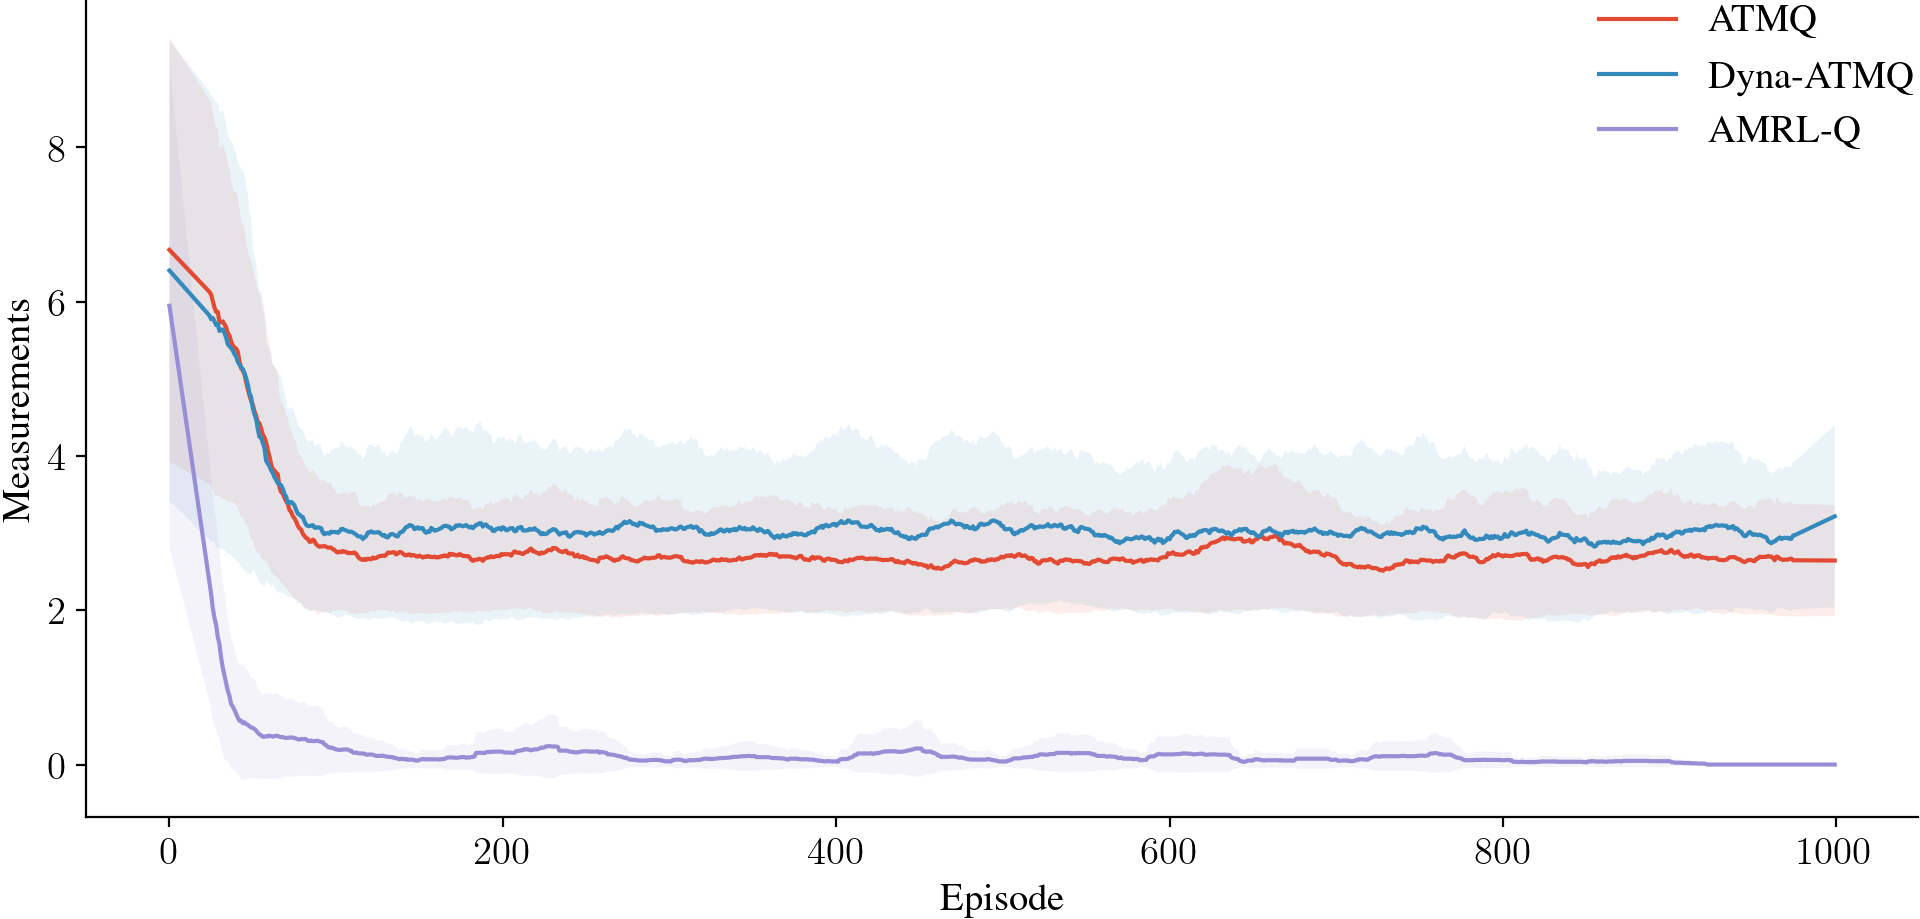

<Figure size 2000x1000 with 0 Axes>

In [22]:
# Make and export plots
for i in range (nmbr_plots):

    plt.ylabel(Plot_Y_Label[i])
    plt.xlabel("Episode")
    
    x = np.arange(eps_to_plot)
    
    if has_ideal_line and i==0:
        plt.plot(x, np.repeat(ideal_value,eps_to_plot), 'k--', linewidth=1, label="optimal value")
    
    for j in range(nmbr_files):
        
        y, std = all_data[i][0][j][:eps_to_plot], all_data[i][1][j][:eps_to_plot]
        y, std = savgol_filter(y, w1,w2), savgol_filter(std, w1,w2)
        miny, maxy = sts.norm.interval(interval, loc=y, scale=std/np.sqrt(nmbr_runs[j]))
        plt.plot(x,y, label=legend_alg[j])
        if plot_std:
            plt.fill_between(x, miny, maxy, alpha=0.1)

    
    plt.legend()
    plt.savefig(Data_path+"Plots/Plot_{}_{}.pdf".format(fileName_env, Plot_names_file[i]))
    if True:
        pass
        #plt.show()
    plt.show()
    plt.clf()

In [23]:
# Create human-readable collected datafiles

file_text = """
Data collected from running in {} , using the following algorithms:
""".format(env_name)

for (i,file_name) in enumerate(Files_to_read):
    with open(Data_path + file_name) as file:
        
        contentDict = json.load(file)
        toi = int(contentDict["parameters"]["nmbr_eps"])
        fromi = m.ceil(toi-50)
        
        rew             = np.array( contentDict["reward_per_eps"] )
        
        this_rew        = np.average  (rew)
        std_rew         = np.std (np.average( rew, axis=1))
        last_rew        = np.average  (rew[:,fromi:toi])
        last_std_rew    = np.std ( np.average( rew[:,fromi:toi], axis=1 ) )
        
        steps = np.array( contentDict["steps_per_eps"] )
        this_steps = np.average  (steps)
        std_steps     = np.std (np.average( steps, axis=0))
        last_steps = np.average  (steps[:,fromi:toi])
        last_std_steps = np.std ( np.average( steps[:,fromi:toi], axis=0 ) )
        
        measures = np.array( contentDict["measurements_per_eps"] )
        this_measures = np.average  (measures)
        std_measures     = np.std (np.average( measures, axis=0))
        last_measures = np.average  (measures[:,fromi:toi])
        last_std_measures = np.std ( np.average( measures[:,fromi:toi], axis=0 ) )
        
        nmbr_eps=int(contentDict["parameters"]["nmbr_eps"])
        nmbr_runs=int(contentDict["parameters"]["nmbr_runs"])
        measure_cost=float(contentDict["parameters"]["m_cost"])



    file_text +="""
{}:
nmbr_eps                    = {}
nmbr_runs                   = {}
measure_cost                = {}

avererage reward            = {}            (with std = {})
average nmbr steps          = {}            (with std = {})
average nmbr measurements   = {}            (with std = {})

In last 1/10th of episodes:
avererage reward            = {}            (with std = {})
average nmbr steps          = {}            (with std = {})
average nmbr measurements   = {}            (with std = {})

""".format(
        fileName_alg[i],
        nmbr_eps, nmbr_runs, measure_cost,
        this_rew, std_rew, this_steps, std_steps, this_measures, std_measures,
        last_rew, last_std_rew, last_steps, last_std_steps, last_measures, last_std_measures
    )

data_file_name = Data_path+"/Compiled/Data_{}.pdf".format(fileName_env)
with open(data_file_name, 'w') as f:
    f.write(file_text)

### Code for plotting returns against lake-size.

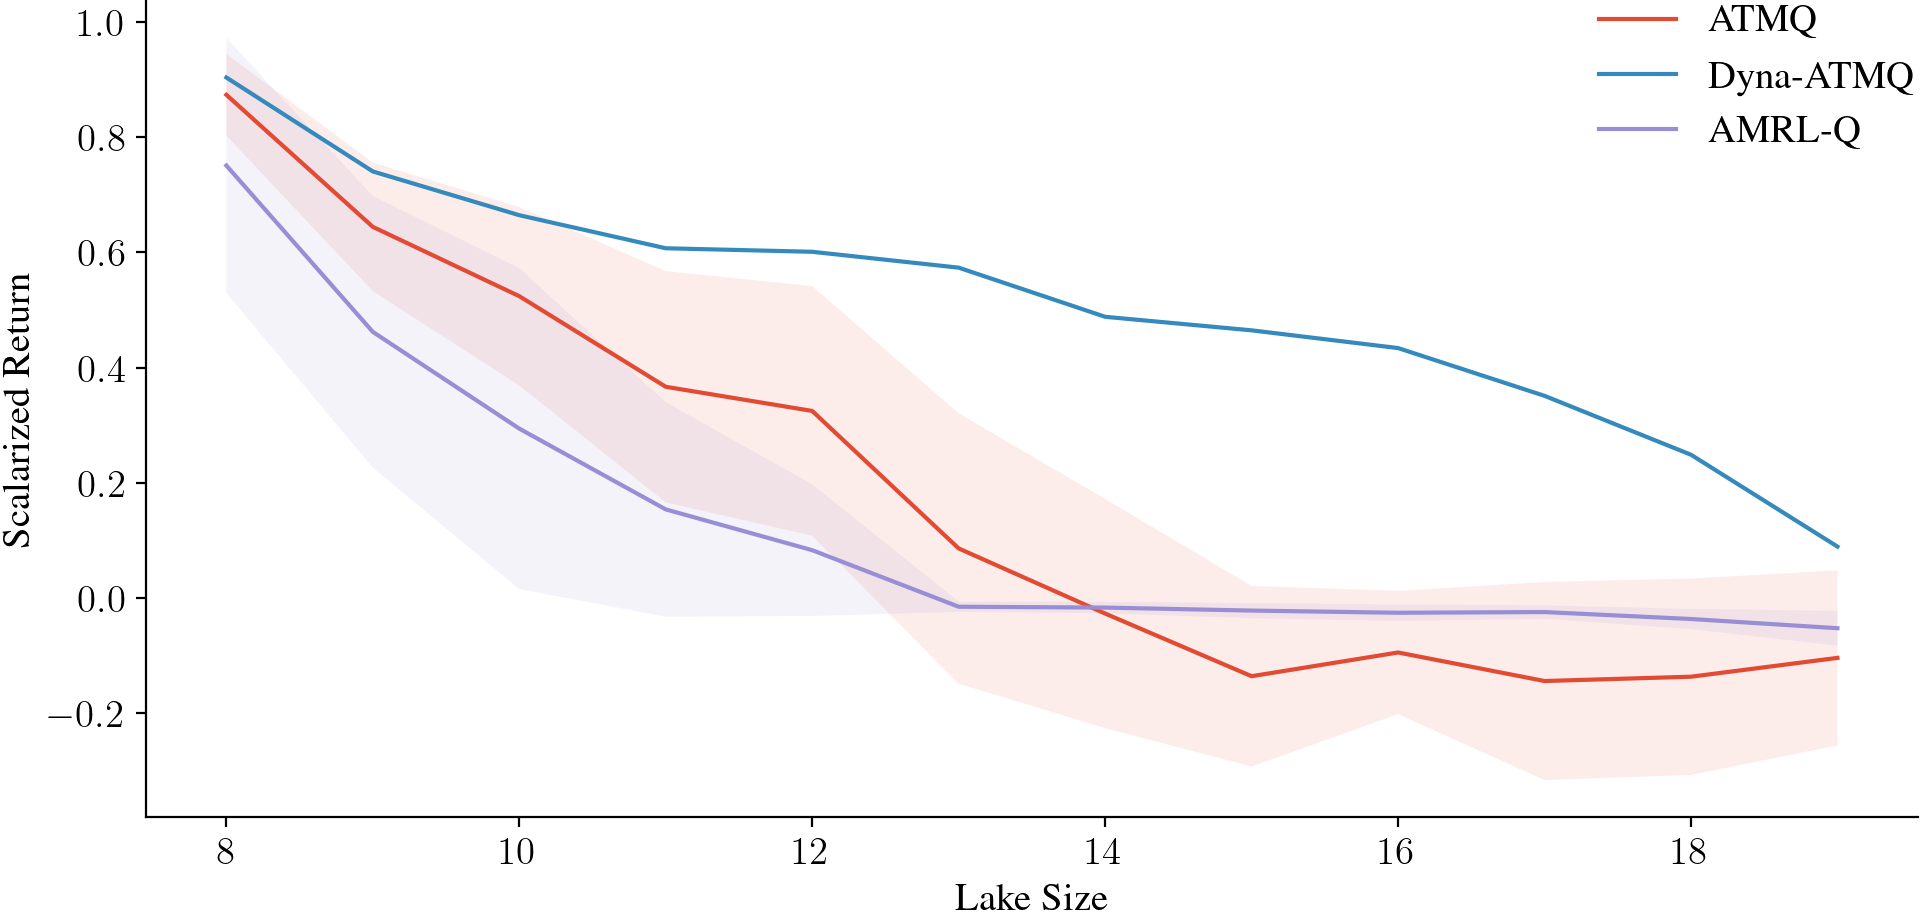

In [24]:

if True:
    

    fileName_alg    = ["BAM_QMDP", "BAM_QMDP+", "AMRL"]
    legend_alg      = ["ATMQ",  "Dyna-ATMQ", "AMRL-Q"]
    nmbr_algs       = len(fileName_alg)

    sizes = np.arange(8,20)
    nmbr_files = len(sizes)
    avg_rewards, avg_measures, std_rewards, std_measures = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))
    rewardsmin, rewardsmax = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))

    check_percentage = 0.9
    this_window, this_order = 3, 1

    # Collect all data
    for (algnmbr, algName) in enumerate(fileName_alg):
        for i in range(nmbr_files):
            filename = "AMData_{}_Lake_random{}_semi-slippery.json".format(fileName_alg[algnmbr],  str(sizes[i]))
            
            with open(Data_path + filename) as file:
                    contentDict = json.load(file)
                    
                    nmbr_eps = int(contentDict["parameters"]["nmbr_eps"])
                    nmbr_runs = int(contentDict["parameters"]["nmbr_runs"])
                    toi = nmbr_eps
                    fromi = m.ceil(toi*check_percentage)
                    
                    rewards = np.array(contentDict["reward_per_eps"])[:,fromi:toi]
                    avg_rewards[algnmbr,i]  = np.average( rewards )
                    std_rewards[algnmbr,i]  = np.std( np.average(rewards, axis=1) )
                    rewardsmin[algnmbr,i], rewardsmax[algnmbr,i] = sts.norm.interval(interval, loc=avg_rewards[algnmbr,i], scale=std_rewards[algnmbr,i])
            
        avg_rewards = savgol_filter( avg_rewards, this_window, this_order)
        std_rewards = savgol_filter( std_rewards, this_window, this_order)
        rewardsmin[algnmbr], rewardsmax[algnmbr] = sts.norm.interval(interval, loc=avg_rewards[algnmbr], scale=std_rewards[algnmbr]/np.sqrt(nmbr_runs))
        
        # Manually remove std for dyna-variant 
        rewardsmin[1], rewardsmax[1] = avg_rewards[1], avg_rewards[1]
        
        plt.plot(sizes, avg_rewards[algnmbr], label = legend_alg[algnmbr])
        if plot_std:
            plt.fill_between(sizes, rewardsmin[algnmbr], rewardsmax[algnmbr], alpha=0.1)


    plt.ylabel("Scalarized Return")
    plt.xlabel("Lake Size")
    plt.legend()
    plt.savefig(Data_path+"Plots/LargeLakeCombined.pdf")
    plt.show()

### Code for plotting normalised returns against measure cost in MeasureValue environment

In [25]:
if False:

    fileName_alg    = ["BAM_QMDP", "BAM_QMDP+", "AMRL", "ACNO_OTP"]
    legend_alg      = ["ATMQ",  "Dyna-ATMQ", "AMRL-Q","ACNO-OTP" ]
    nmbr_algs       = len(fileName_alg)
    
    this_window, this_order = 3, 1

    costs = np.linspace(start=0.05, stop=0.2, num=16)
    costs_names = ["005","006", "007", "008", "009", "01", "011", "012", "013", "014", "015", "016", "017", "018", "019", "02"]
    # costs = np.linspace(start=0.06, stop=0.2, num=8)
    # cost_names = ["006", "008", "01", "012", "014", "016", "018", "02"]
    nmbr_files = len(costs)
    avg_rewards, avg_measures, std_rewards, std_measures = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))
    rewardsmin, rewardsmax = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))

    nmbr_points = nmbr_files
    costs_extended = np.linspace(np.min(costs), np.max(costs), nmbr_points)
    optimal_line = (0.8-costs_extended) / 0.8
    optimal_line[optimal_line < 0.8] = 0.8

    # Collect all data
    for (algnmbr, algName) in enumerate(fileName_alg):
        for i in range(nmbr_files):
            filename = "AMData_{}_Loss_{}.json".format(fileName_alg[algnmbr],  str(costs_names[i]))
            
            with open(Data_path + filename) as file:
                contentDict = json.load(file)
                
                nmbr_eps = int(contentDict["parameters"]["nmbr_eps"])
                nmbr_runs = int(contentDict["parameters"]["nmbr_runs"])
                toi = nmbr_eps
                fromi = nmbr_eps-50
                
                rewards = np.array(contentDict["reward_per_eps"])[:,fromi:toi] / optimal_line[i] *100
                avg_rewards[algnmbr,i]  = np.average( rewards ) 
                std_rewards[algnmbr,i]  = np.std( np.average(rewards, axis=1) )
                rewardsmin[algnmbr,i], rewardsmax[algnmbr,i] = sts.norm.interval(interval, loc=avg_rewards[algnmbr,i], scale=std_rewards[algnmbr,i]/np.sqrt(nmbr_runs))
            
        avg_rewards = savgol_filter( avg_rewards, this_window, this_order)
        std_rewards = savgol_filter( std_rewards, this_window, this_order)
        # rewardsmin, rewardsmax = avg_rewards - std_rewards, avg_rewards + std_rewards, 
        # rewardsmin[algnmbr], rewardsmax[algnmbr] = sts.norm.interval(interval, loc=avg_rewards[algnmbr], scale=std_rewards[algnmbr])
        
        plt.plot(costs, avg_rewards[algnmbr], label = legend_alg[algnmbr])
        if plot_std:
            plt.fill_between(costs, rewardsmin[algnmbr], rewardsmax[algnmbr], alpha=0.15)
    

    plt.plot(costs_extended, np.repeat(100,nmbr_points), 'k--', linewidth=1, label="Optimal behaviour" )
    
    #plt.title("Average Return against measuring cost")
    plt.ylabel("Average return (% of optimal)")
    plt.xlabel("Measurement Cost")
    plt.legend()
    plt.show()

### Code for measurements agains measuring cost in MV environment

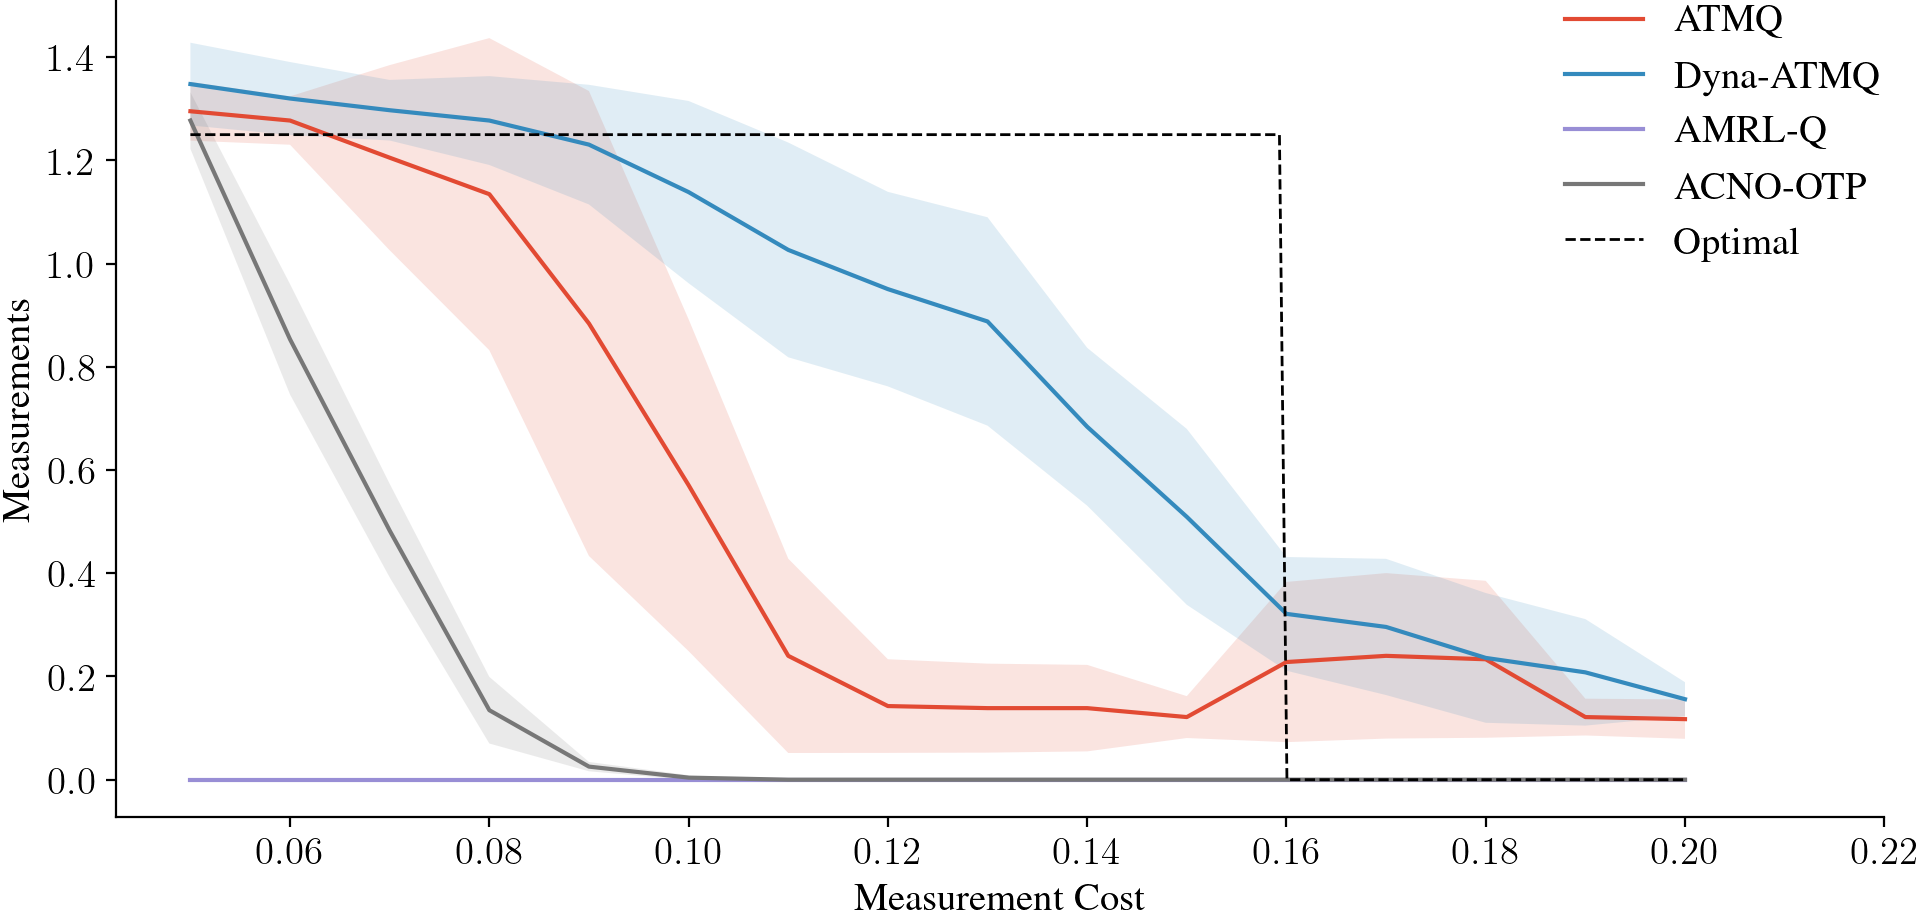

In [26]:
if True:

    fileName_alg    = ["BAM_QMDP", "BAM_QMDP+", "AMRL", "ACNO_OTP"]
    legend_alg      = ["ATMQ",  "Dyna-ATMQ", "AMRL-Q","ACNO-OTP" ]
    nmbr_algs       = len(fileName_alg)
    
    this_window, this_order = 3, 1

    costs = np.linspace(start=0.05, stop=0.2, num=16)
    costs_names = ["005","006", "007", "008", "009", "01", "011", "012", "013", "014", "015", "016", "017", "018", "019", "02"]
    # costs = np.linspace(start=0.06, stop=0.2, num=8)
    # cost_names = ["006", "008", "01", "012", "014", "016", "018", "02"]
    nmbr_files = len(costs)
    avg_rewards, avg_measures, std_rewards, std_measures = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))
    rewardsmin, rewardsmax = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))

    nmbr_points = 200
    costs_extended = np.linspace(np.min(costs), np.max(costs), nmbr_points)
    
    optimal_line = np.zeros(nmbr_points)+1.25
    optimal_line[costs_extended>0.16] = 0
    
    # plt.axvline(x=0.16, color='k', linestyle='--', label="optimal value")


    # Collect all data
    for (algnmbr, algName) in enumerate(fileName_alg):
        for i in range(nmbr_files):
            filename = "AMData_{}_Loss_{}.json".format(fileName_alg[algnmbr],  str(costs_names[i]))
            
            with open(Data_path + filename) as file:
                contentDict = json.load(file)
                
                nmbr_eps = int(contentDict["parameters"]["nmbr_eps"])
                nmbr_runs = int(contentDict["parameters"]["nmbr_runs"])
                toi = nmbr_eps
                fromi = nmbr_eps-50
                
                rewards = np.array(contentDict["measurements_per_eps"])[:,fromi:toi]
                avg_rewards[algnmbr,i]  = np.average( rewards )
                std_rewards[algnmbr,i]  = np.std( np.average(rewards, axis=1) )
                #rewardsmin[algnmbr,i], rewardsmax[algnmbr,i] = sts.norm.interval(interval, loc=avg_rewards[algnmbr,i], scale=std_rewards[algnmbr,i])
            
        avg_rewards = savgol_filter( avg_rewards, this_window, this_order)
        std_rewards = savgol_filter( std_rewards, this_window, this_order)
        rewardsmin[algnmbr], rewardsmax[algnmbr] = sts.norm.interval(interval, loc=avg_rewards[algnmbr], scale=std_rewards[algnmbr]/np.sqrt(nmbr_runs))
        
        plt.plot(costs, avg_rewards[algnmbr], label = legend_alg[algnmbr])
        if plot_std:
            plt.fill_between(costs, rewardsmin[algnmbr], rewardsmax[algnmbr], alpha=0.15)
    #plt.title("Average Return against measuring cost")
    
    plt.plot(costs_extended, optimal_line, 'k--',linewidth=1, label="Optimal")
    plt.xlim(right=0.22)
    
    plt.ylabel("Measurements")
    plt.xlabel("Measurement Cost")
    plt.legend()
    plt.savefig(Data_path+"Plots/RegretCostsCombinedMeasures.pdf")
    plt.show()

### Code for returns agains measuring cost in MV environment

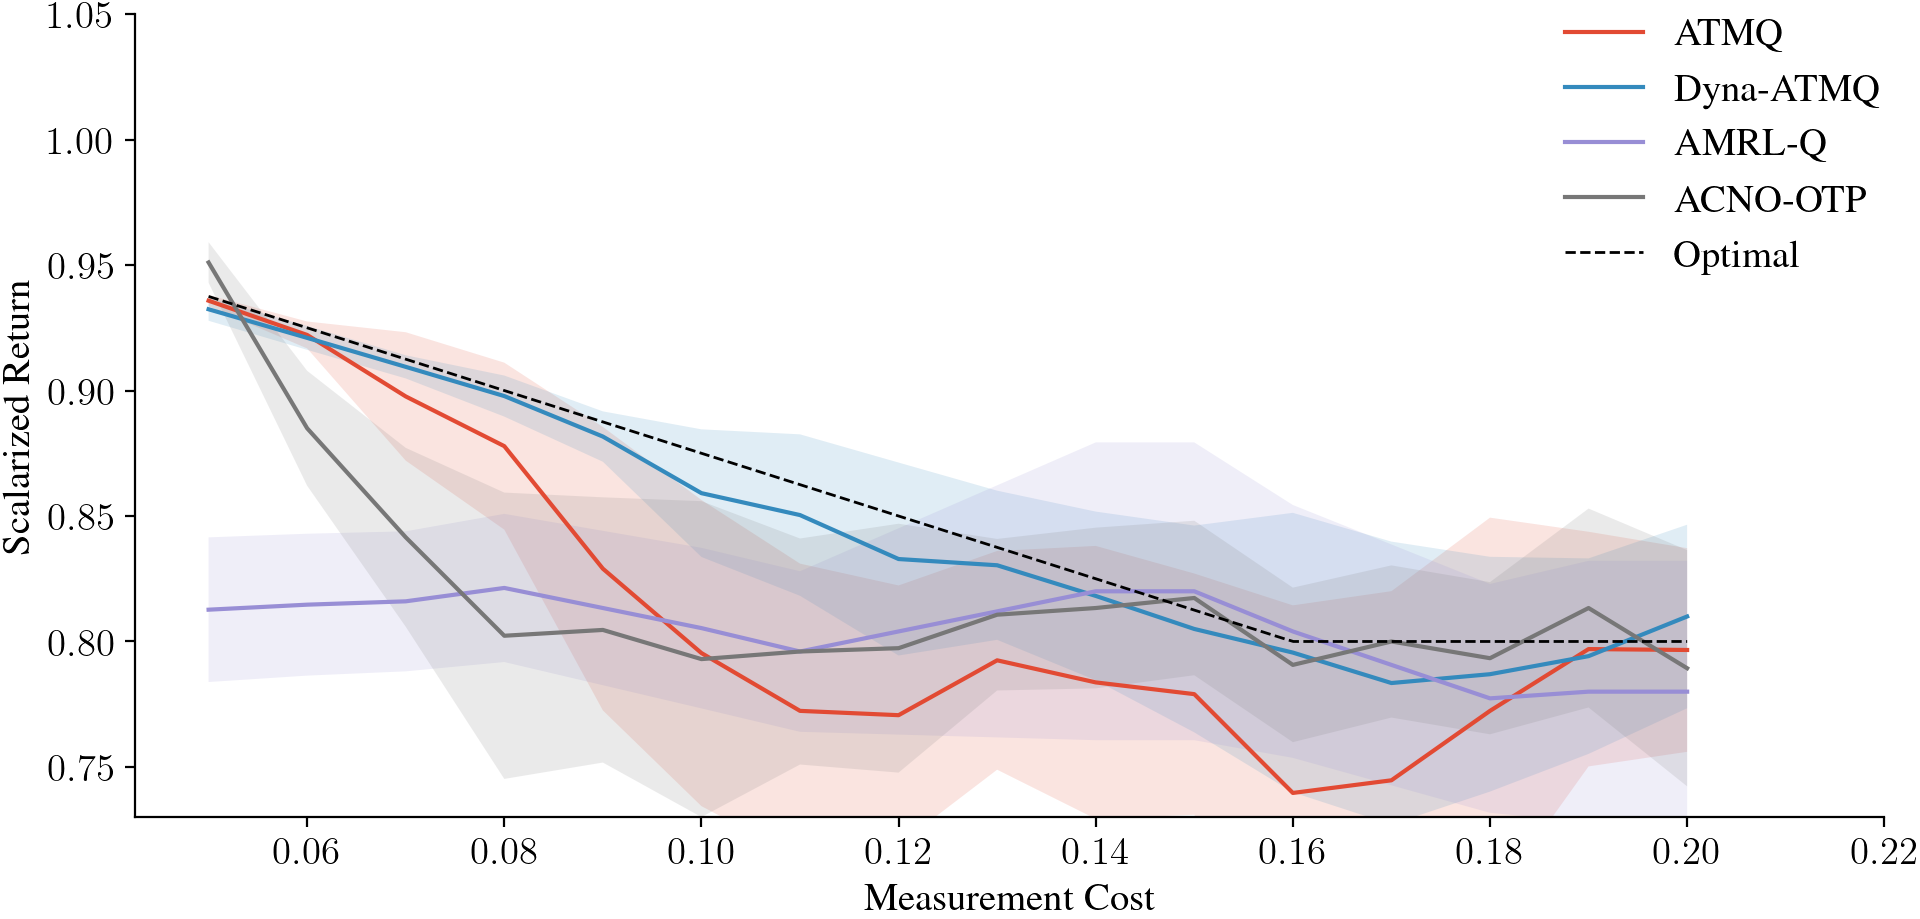

In [27]:
if True:

    fileName_alg    = ["BAM_QMDP", "BAM_QMDP+", "AMRL", "ACNO_OTP"]
    legend_alg      = ["ATMQ",  "Dyna-ATMQ", "AMRL-Q","ACNO-OTP" ]
    nmbr_algs       = len(fileName_alg)
    
    this_window, this_order = 3, 1

    costs = np.linspace(start=0.05, stop=0.2, num=16)
    costs_names = ["005","006", "007", "008", "009", "01", "011", "012", "013", "014", "015", "016", "017", "018", "019", "02"]
    # costs = np.linspace(start=0.06, stop=0.2, num=8)
    # cost_names = ["006", "008", "01", "012", "014", "016", "018", "02"]
    nmbr_files = len(costs)
    avg_rewards, avg_measures, std_rewards, std_measures = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))
    rewardsmin, rewardsmax = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))

    nmbr_points = 200
    costs_extended = np.linspace(np.min(costs), np.max(costs), nmbr_points)
    optimal_line = (0.8-costs_extended) / 0.8
    optimal_line[optimal_line < 0.8] = 0.8
    
    
    # plt.axvline(x=0.16, color='k', linestyle='--', label="optimal value")


    # Collect all data
    for (algnmbr, algName) in enumerate(fileName_alg):
        for i in range(nmbr_files):
            filename = "AMData_{}_Loss_{}.json".format(fileName_alg[algnmbr],  str(costs_names[i]))
            
            with open(Data_path + filename) as file:
                contentDict = json.load(file)
                
                nmbr_eps = int(contentDict["parameters"]["nmbr_eps"])
                nmbr_runs = int(contentDict["parameters"]["nmbr_runs"])
                toi = nmbr_eps
                fromi = nmbr_eps-50
                
                rewards = np.array(contentDict["reward_per_eps"])[:,fromi:toi]
                avg_rewards[algnmbr,i]  = np.average( rewards )
                std_rewards[algnmbr,i]  = np.std( np.average(rewards, axis=1) )
                #rewardsmin[algnmbr,i], rewardsmax[algnmbr,i] = sts.norm.interval(interval, loc=avg_rewards[algnmbr,i], scale=std_rewards[algnmbr,i])
            
        avg_rewards = savgol_filter( avg_rewards, this_window, this_order)
        std_rewards = savgol_filter( std_rewards, this_window, this_order)
        rewardsmin[algnmbr], rewardsmax[algnmbr] = sts.norm.interval(interval, loc=avg_rewards[algnmbr], scale=std_rewards[algnmbr]/np.sqrt(nmbr_runs))
        rewardsmin, rewardsmax = avg_rewards - std_rewards, avg_rewards + std_rewards, 
        
        plt.plot(costs, avg_rewards[algnmbr], label = legend_alg[algnmbr])
        if plot_std:
            plt.fill_between(costs, rewardsmin[algnmbr], rewardsmax[algnmbr], alpha=0.15)
            plt.ylim(ymin=0.73, ymax=0.97)

    plt.plot(costs_extended, optimal_line, 'k--',linewidth=1, label="Optimal")
    plt.ylabel("Scalarized Return")
    
    plt.ylim(top = 1.05)
    plt.xlim(right=0.22)
    plt.xlabel("Measurement Cost")
    plt.legend()
    plt.savefig(Data_path+"Plots/RegretCostsCombined.pdf")
    plt.show()

# NEW CODE

### Generic functions

In [28]:
def float_to_str(float):
        if np.isclose(float, 0):
                return "0"
        elif float<0:
                return "-" + float_to_str(-float)
        elif float >= 1:
                prefix = int(np.floor(float))
                return str(prefix) + float_to_str(float - prefix)[1:]
        elif float < 1:
                cutlength = np.min([len(str(float)), 7])
                return "0" + (str(float)[:cutlength].rstrip('0')[2:])

def collect_data_from_files(
        algnames:list, resultvars:list, tests:np.ndarray,
        str1:str, str2:str, str3:str,
        nmbr_runs:int = 1, plotEpStart:int = 0, plotEpEnd:int = -1,
        per_run_std:bool = False,
        smoothen:bool = False, window:int = 3, order:int = 1
        ):
        
        nmbr_algs = len(algnames)
        nmbr_tests = len(tests)
        nmbr_results = len(resultvars)        
        avgs = np.zeros((nmbr_algs, nmbr_results, nmbr_tests))
        stds = np.zeros((nmbr_algs, nmbr_results, nmbr_tests))
        
        for (alg_iter, algname) in enumerate(algnames):
                for test_iter in range(nmbr_tests):
                        filename = str1 + algname + str2 + float_to_str(tests[test_iter]) + str3
                        with open(filename) as file:
                                file_results = json.load(file)
                                for (result_iter, result_name) in enumerate(resultvars):
                                        this_results = np.array(file_results[result_name])
                                        avgs[alg_iter, result_iter, test_iter] = np.average(this_results[:,plotEpStart:plotEpEnd])
                                        
                                        if per_run_std:
                                                stds[alg_iter, result_iter, test_iter] = np.std( np.average(rewards, axis=1) )  / np.sqrt(nmbr_runs)
                                        else:
                                                stds[alg_iter, result_iter, test_iter] = np.std( np.average(rewards) )          / np.sqrt( (plotEpEnd - plotEpStart) * nmbr_runs )
                                        
        if smoothen:
                for (alg_iter, algname) in enumerate(algnames):
                        for (result_iter, result_name) in enumerate(resultvars):
                                avgs[alg_iter, result_iter] = savgol_filter(avgs[alg_iter, result_iter],window, order, mode="nearest")
                                stds[alg_iter, result_iter] = savgol_filter(stds[alg_iter, result_iter],window, order, mode="nearest")
        return (avgs, stds)

def plot_lines(
        ys:np.ndarray, x:np.ndarray,
        stds:np.ndarray = None, conf_interval:float = 0.95,
        legend:np.ndarray = None, title:str="",
        xlabel:str = "", ylabel:str="",
        show:bool=True, safe:bool = False, safename:str = "Temp.pdf", clear:bool = False
):
        for (i, y) in enumerate(ys):
                if legend is not None:
                        plt.plot(x, y, label = legend[i])
                else:
                        plt.plot(x, y)
                if stds is not None:
                        rewardsmin, rewardsmax = sts.norm.interval(conf_interval, loc=y, scale=stds[i])
                        plt.fill_between(x, rewardsmin, rewardsmax, alpha=0.1)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.title(title)
        plt.legend()
        if safe:
                plt.savefig(safename)
        if clear:
                plt.clf()
        if show:
                plt.show()

### Test on Machine Maintenance

C:\Users\merli\AppData\Local\Temp\ipykernel_2668\2567627454.py:39: RuntimeWarning: invalid value encountered in sqrt
  stds[alg_iter, result_iter, test_iter] = np.std( np.average(rewards) )          / np.sqrt( (plotEpEnd - plotEpStart) * nmbr_runs )


IndexError: list index out of range

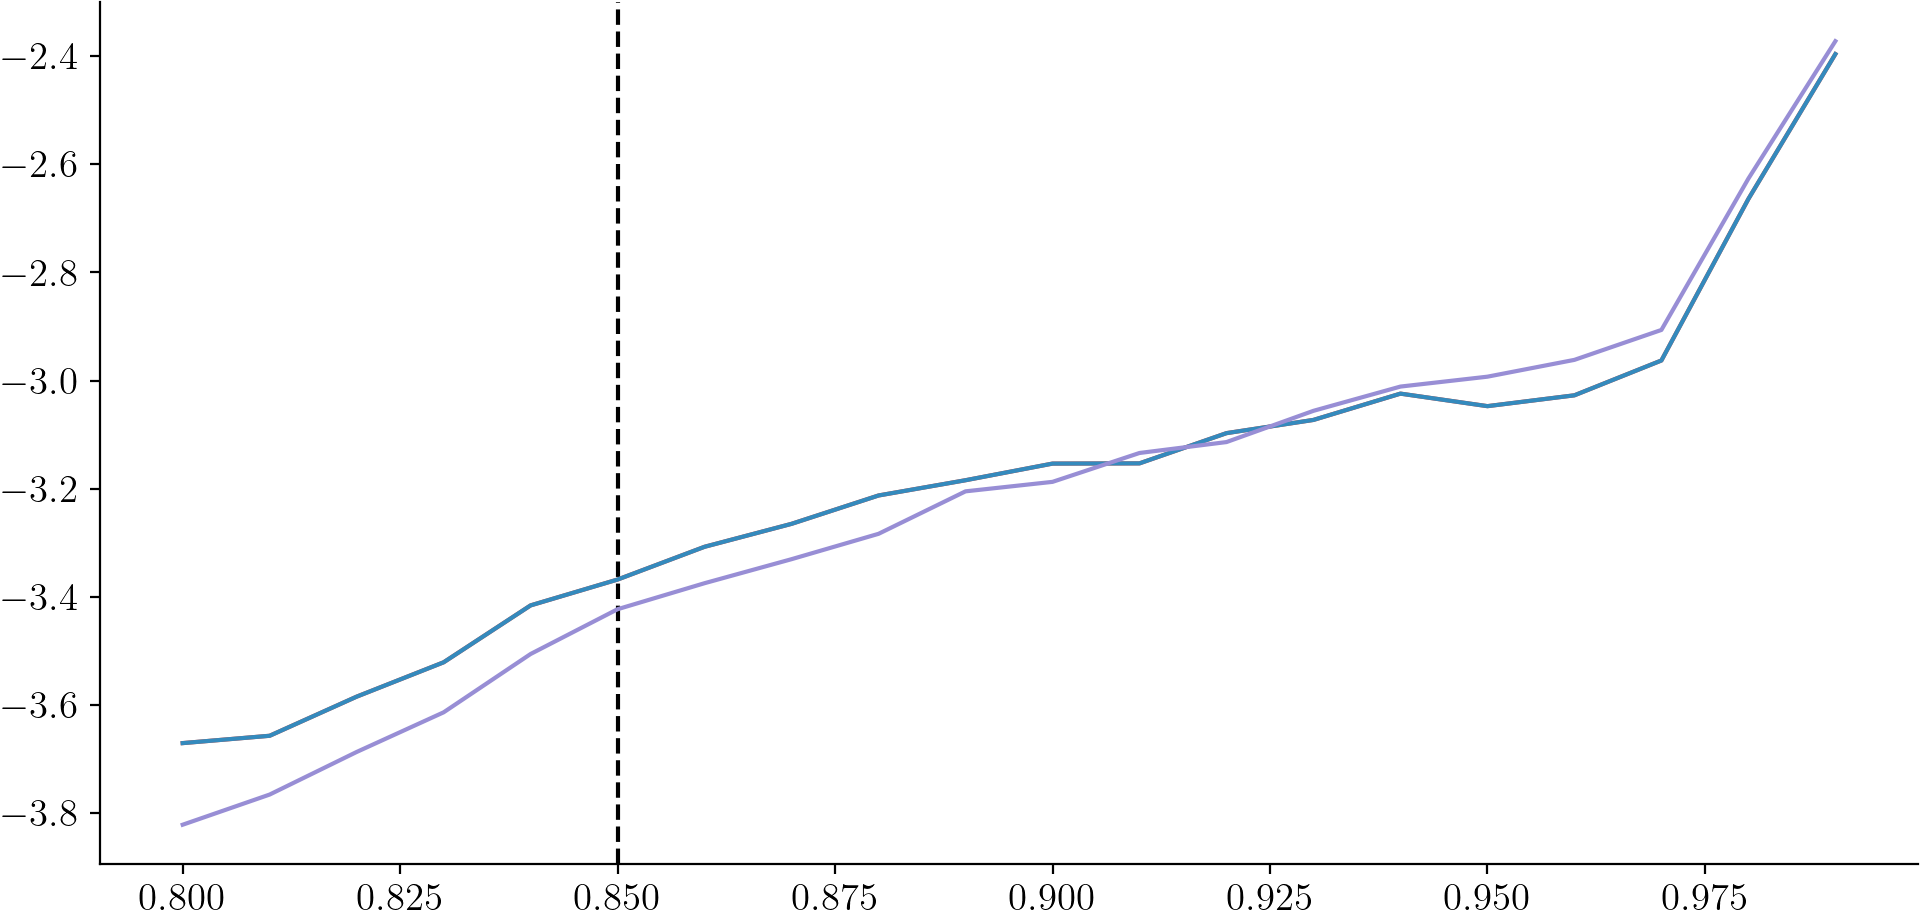

In [39]:
# Regular runs
plan_value = 0.85
# algnames = ["ATM", "ATM_RMDP", "ATM_Robust", "ATM_Control_Robust"]
algnames = ["ATM_RMDP", "ATM_Robust"]
# algnames = ["ATM_Robust", "ATM_Control_Robust"]
resultvars = ["reward_per_eps", "steps_per_eps", "measurements_per_eps"]
alphas = np.round(np.arange(start=0.8, stop=1.0, step=0.01), decimals=2)
str1 = "Data/Temp1/AMData_"; str2 = "_Maintenance_N8_r"; str3 ="_p{}_mc001.json".format(float_to_str(plan_value))

nmbralgs, nmbrresults, nmbrtests = np.size(algnames), np.size(resultvars), np.size(alphas)
nmbr_extra_algs = 2
all_avgs, all_stds = np.ones((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests))
all_avgs[:nmbralgs], all_stds[:nmbralgs] = collect_data_from_files(algnames, resultvars, alphas, str1, str2, str3, smoothen=True)

# Optimistic and pesimistic Control robustness
algnames = ["ATM_Control_Robust"]
# str3 = "_p{}_m1_mc001.json".format(float_to_str(plan_value))
# all_avgs[nmbralgs], all_stds[nmbralgs] = collect_data_from_files(algnames, resultvars, alphas, str1, str2, str3, smoothen=True)

str3 = "_p{}_m-1_mc001.json".format(float_to_str(plan_value))
all_avgs[nmbralgs], all_stds[nmbralgs] = collect_data_from_files(algnames, resultvars, alphas, str1, str2, str3, smoothen=True)

avg_rewards, std_rewards = all_avgs[:,0,:], all_stds[:,0,:]
avg_measures, std_measures = all_avgs[:,2,:], all_stds[:,2,:]
avg_steps, std_steps = all_avgs[:,1,:], all_stds[:,1,:]

# legend = ["ATM","ATM (using RMDP env)", "ATM_Robust", "ATM_Control_Robust (pes)", "ATM_Control_Robust (avg)", "ATM_Control_Robust (opt)"]
legend = ["ATM (RMDP)", "ATM_Robust","ATM_Control_Robust (opt)"]
# legend = [ "ATM_Robust", "ATM_Control_Robust (pes)", "ATM_Control_Robust (avg)", "ATM_Control_Robust (opt)"]

xaxis = "Alpha (real)"
yaxis_r = "Reward"
yaxis_m = "Measurements"
yaxis_s = "Steps"

plt.axvline(x=plan_value, color='k', linestyle='--', label="planning alpha")
plot_lines(avg_rewards, alphas, std_rewards, legend=legend, xlabel=xaxis, ylabel=yaxis_r)
plt.axvline(x=plan_value, color='k', linestyle='--', label="planning alpha")
plot_lines(avg_measures, alphas, std_measures, legend=legend, xlabel=xaxis, ylabel=yaxis_m)
plt.axvline(x=plan_value, color='k', linestyle='--', label="planning alpha")
plot_lines(avg_steps, alphas, std_steps, legend=legend, xlabel=xaxis, ylabel=yaxis_s)
# Without non-robust ATM
# plot_lines(avg_rewards[1:], alphas, std_rewards[1:], legend=legend[1:])

Data\Temp1\AMData_ATM_Maintenance_N8_r08_p09_mc001.json
Data\Temp1\AMData_ATM_Maintenance_N8_r08_p09_mc001.json

### Test on 12x12 Frozen Lake

['ATM_RMDP', 'ATM_Robust', 'ATM_Control_Robust'] 4


C:\Users\merli\AppData\Local\Temp\ipykernel_2668\2567627454.py:39: RuntimeWarning: invalid value encountered in sqrt
  stds[alg_iter, result_iter, test_iter] = np.std( np.average(rewards) )          / np.sqrt( (plotEpEnd - plotEpStart) * nmbr_runs )


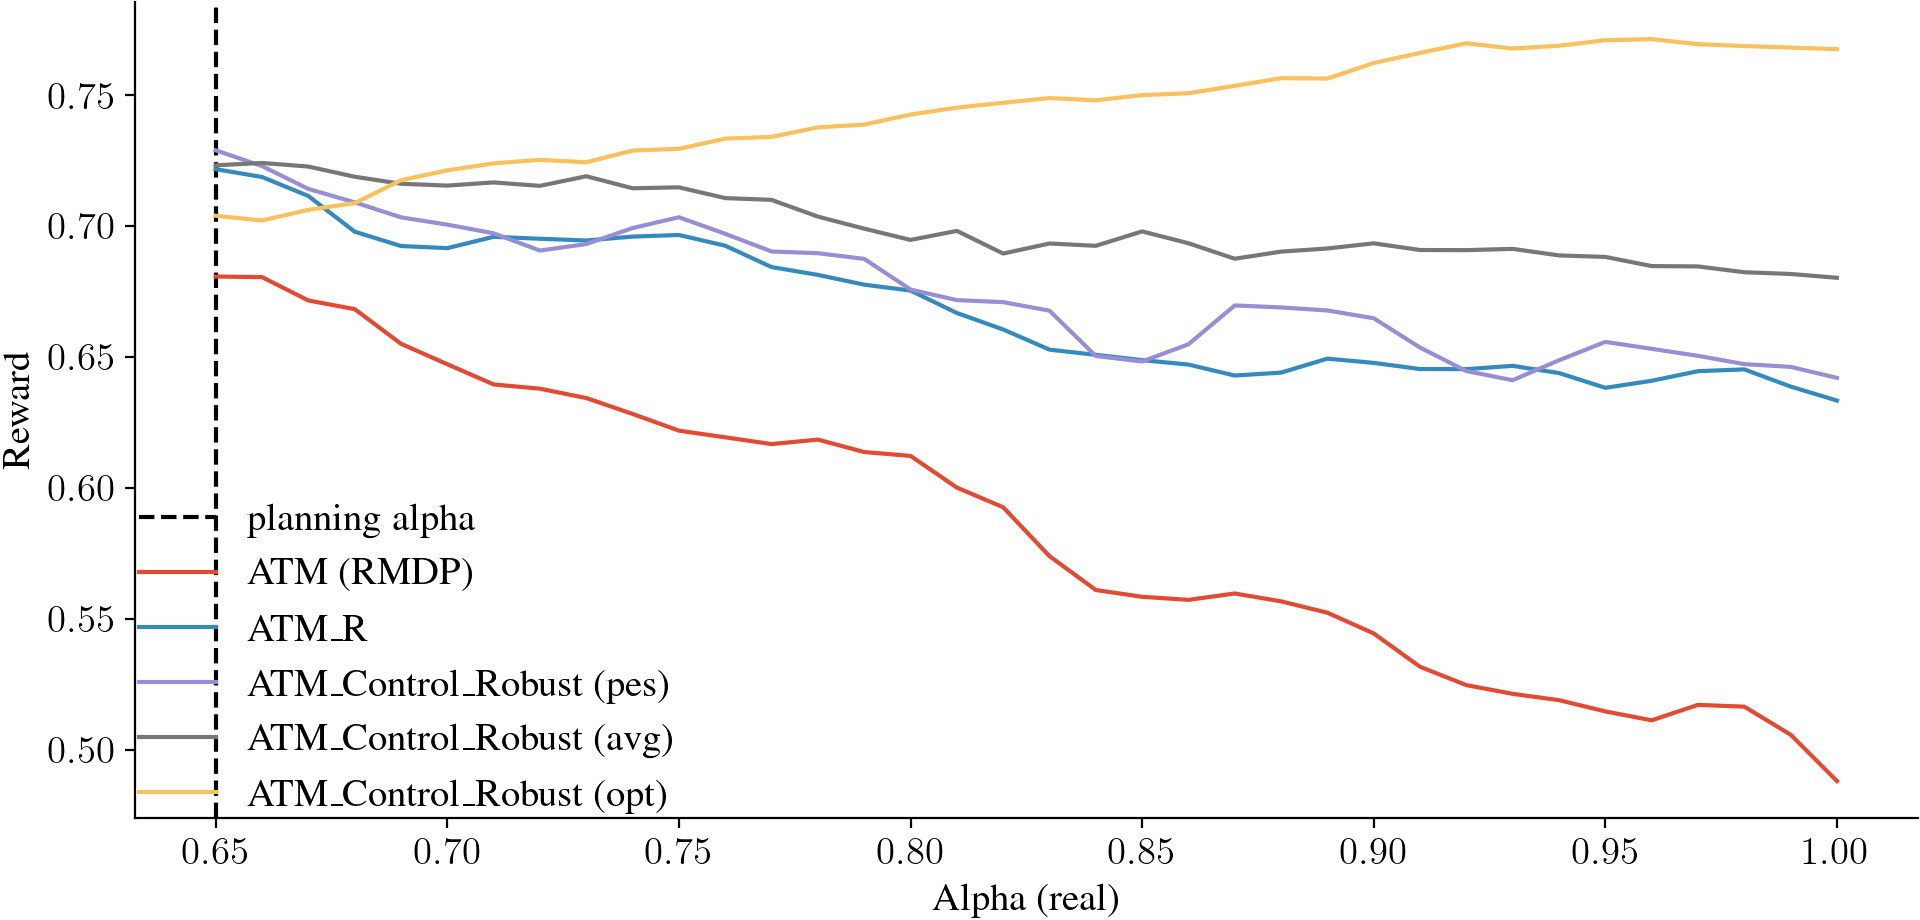

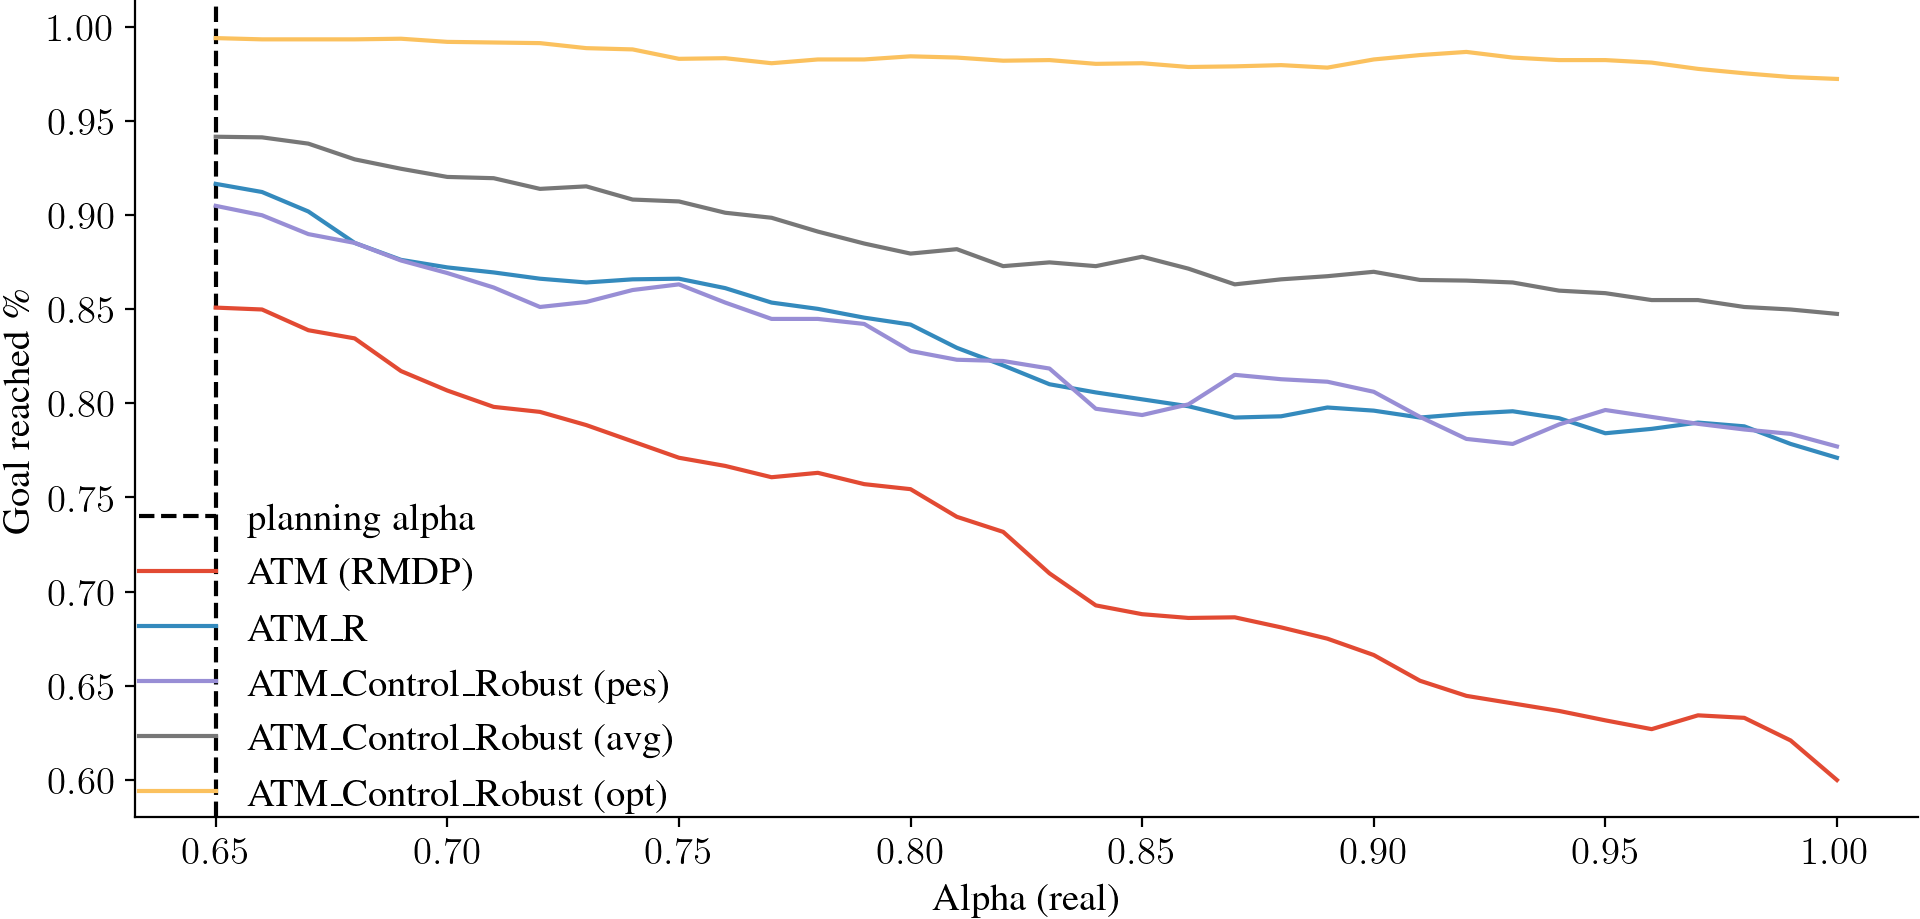

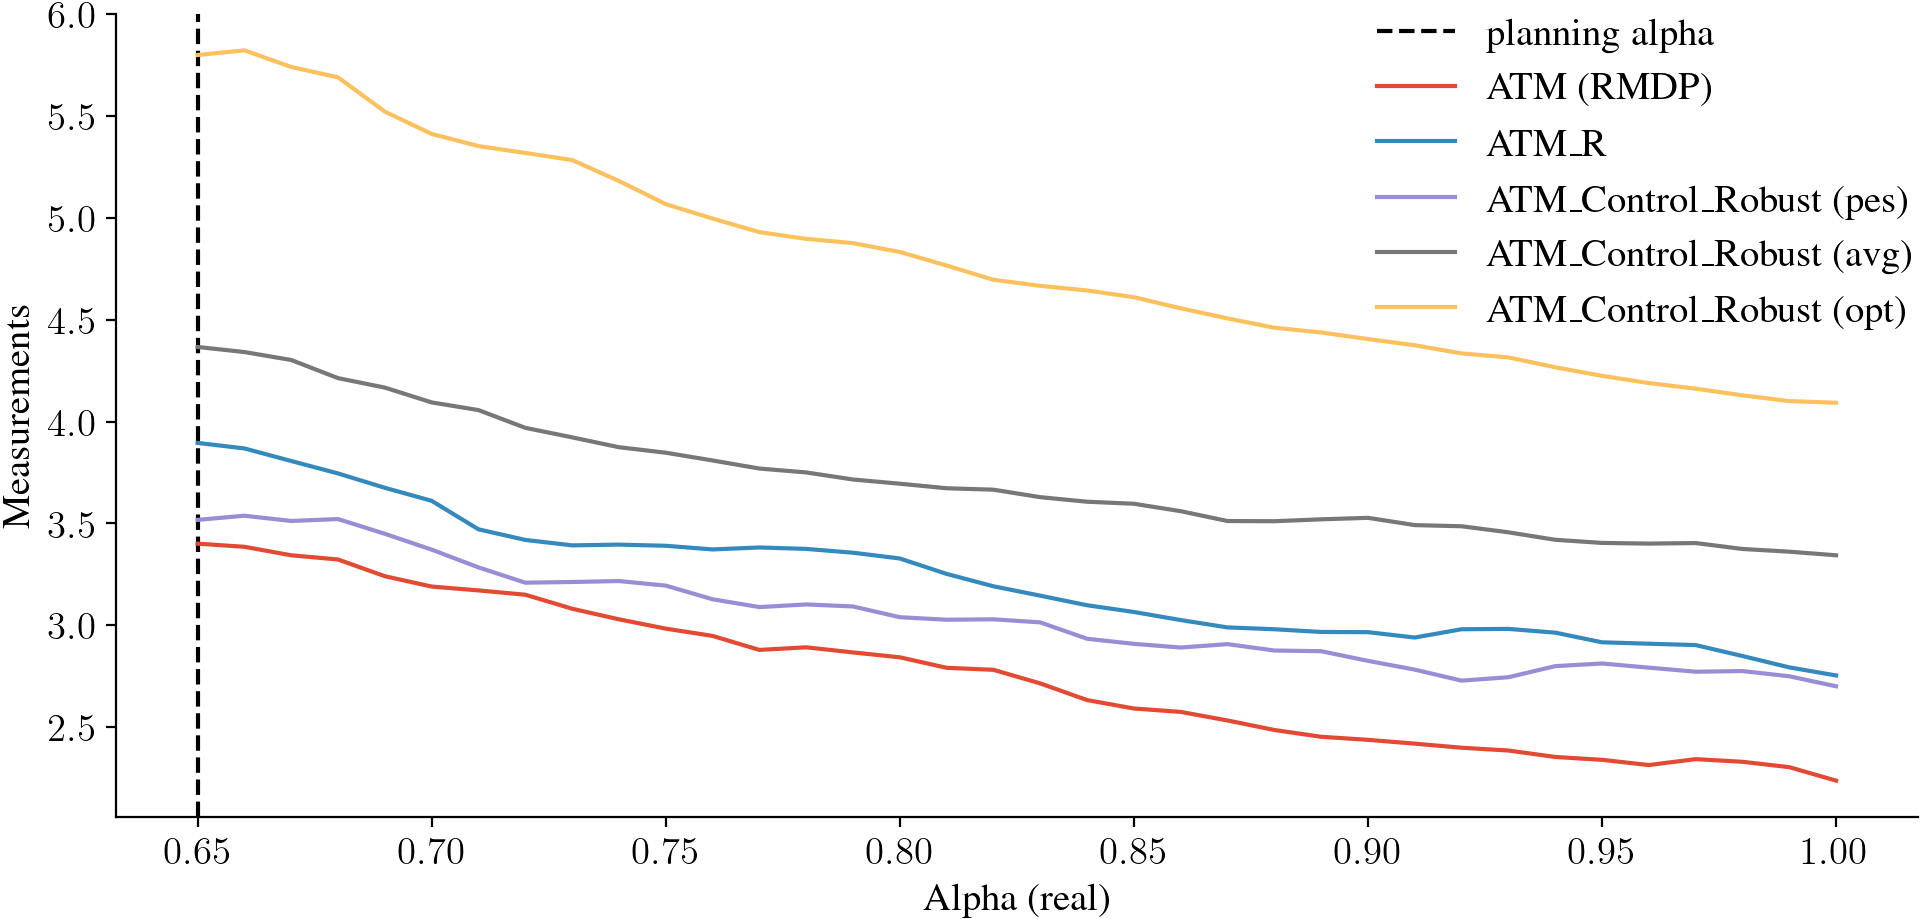

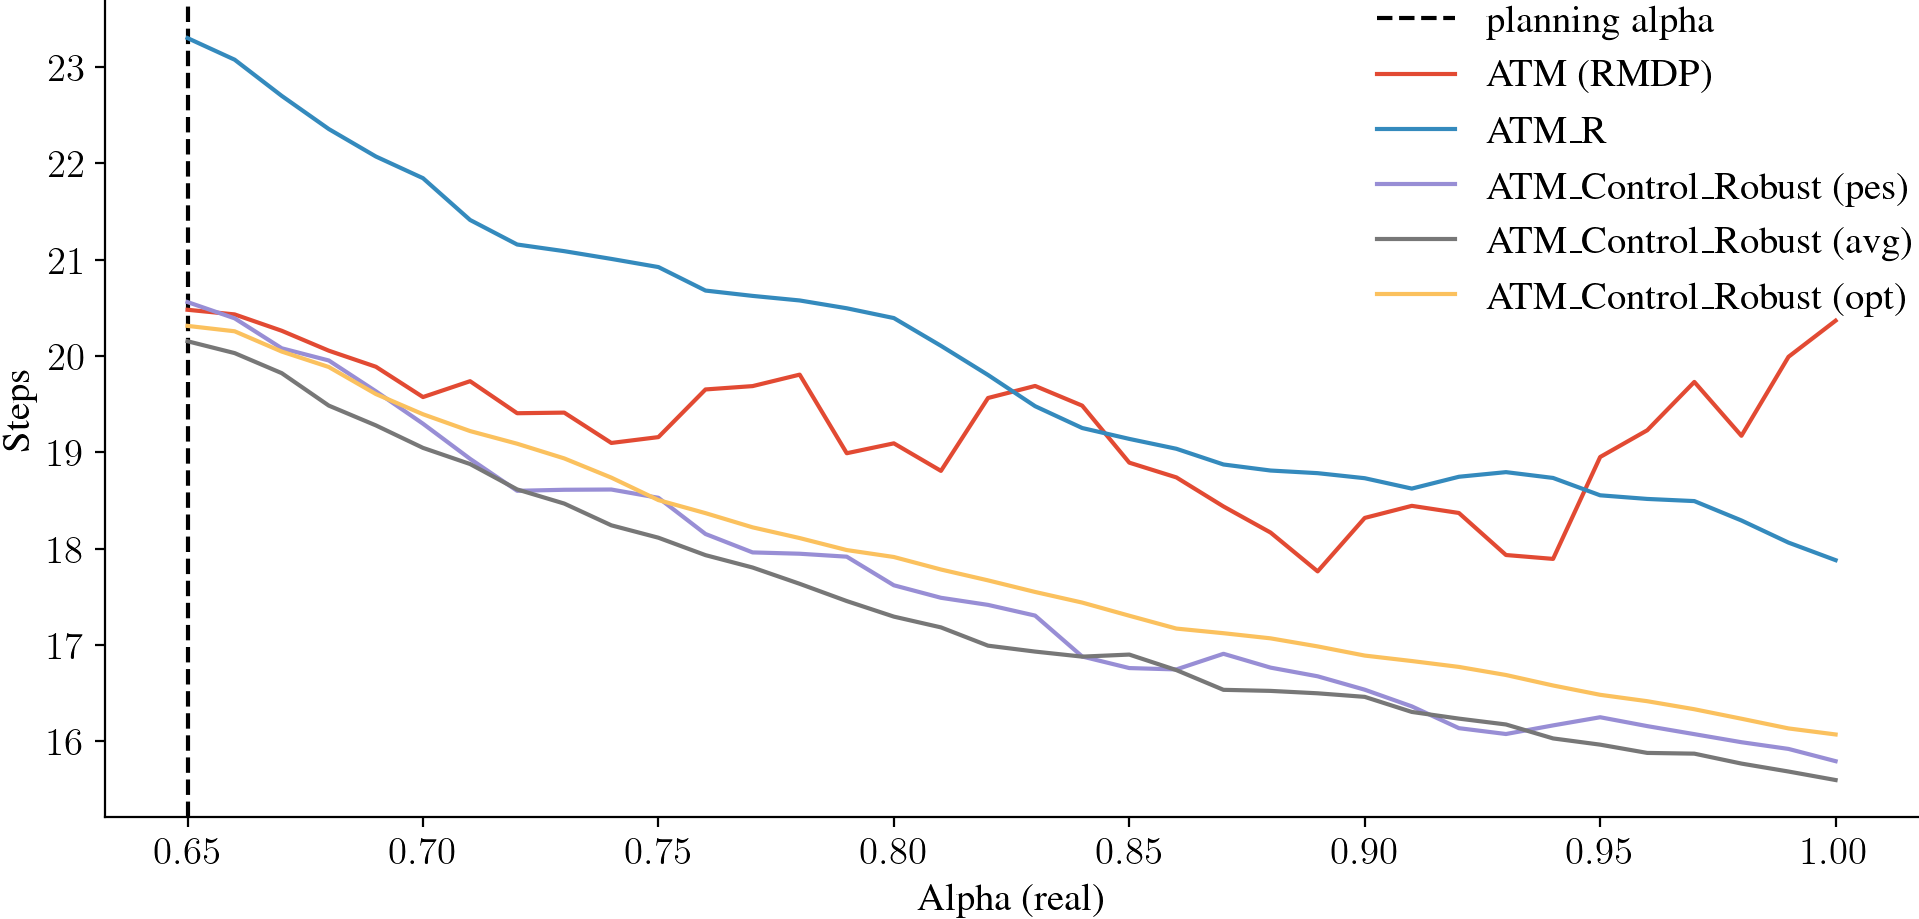

In [30]:
# Regular runs
plan_value = 0.65
# algnames = ["ATM", "ATM_RMDP", "ATM_Robust", "ATM_Control_Robust"]
# algnames = ["ATM", "ATM_Robust", "ATM_Control_Robust"]
algnames = [ "ATM_RMDP", "ATM_Robust", "ATM_Control_Robust"]
# algnames = [ "ATM_RMDP", "ATM_Robust"]
resultvars = ["reward_per_eps", "steps_per_eps", "measurements_per_eps"]
alphas = np.round(np.arange(start=0.65, stop=1.01, step=0.01), decimals=2)
str1 = "Data/Temp1/Lake/AMData_"; str2 = "_Lake_12_semi-slippery_r"; str3 = "_p{}_mc005.json".format(float_to_str(plan_value))

nmbralgs, nmbrresults, nmbrtests = np.size(algnames), np.size(resultvars), np.size(alphas)
nmbr_extra_algs = 2
all_avgs, all_stds = np.empty((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests)), np.empty((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests))
all_avgs[:nmbralgs], all_stds[:nmbralgs] = collect_data_from_files(algnames, resultvars, alphas, str1, str2, str3, smoothen=True)

# Optimistic and pesimistic Control robustness
algnames = ["ATM_Control_Robust"]
str3 = "_p{}_m1_mc005.json".format(float_to_str(plan_value))
all_avgs[nmbralgs], all_stds[nmbralgs] = collect_data_from_files(algnames, resultvars, alphas, str1, str2, str3, smoothen=True)

str3 = "_p{0}_m-{0}_mc005.json".format(float_to_str(plan_value))
all_avgs[nmbralgs+1], all_stds[nmbralgs+1] = collect_data_from_files(algnames, resultvars, alphas, str1, str2, str3, smoothen=True)

avg_rewards, std_rewards = all_avgs[:,0,:], all_stds[:,0,:]
avg_measures, std_measures = all_avgs[:,2,:], all_stds[:,2,:]
avg_steps, std_steps = all_avgs[:,1,:], all_stds[:,1,:]

# avg_rewards += avg_measures*0.05

# legend = ["ATM (avg)", "ATM (using RMDP)", "ATM_Robust", "ATM_Control_Robust (pes)", "ATM_Control_Robust (avg)", "ATM_Control_Robust (opt)"]
legend = ["ATM (RMDP)", "ATM_R", "ATM_Control_Robust (pes)", "ATM_Control_Robust (avg)", "ATM_Control_Robust (opt)"]
# legend = ["ATM (RMDP)", "ATM_Robust", "ATM_Control_Robust (opt)"]
# legend = ["ATM (RMDP)", "ATM_Robust", "ATM_Control_Robust (pes)", "ATM_Control_Robust (opt)"]

xaxis = "Alpha (real)"
yaxis_r = "Reward"
yaxis_rm = "Goal reached \%"
yaxis_m = "Measurements"
yaxis_s = "Steps"

plt.axvline(x=plan_value, color='k', linestyle='--', label="planning alpha")
plot_lines(avg_rewards, alphas, std_rewards, legend=legend, xlabel=xaxis, ylabel=yaxis_r)
plt.axvline(x=plan_value, color='k', linestyle='--', label="planning alpha")
plot_lines(avg_rewards+avg_measures*0.05, alphas, std_rewards, legend=legend, xlabel=xaxis, ylabel=yaxis_rm)

plt.axvline(x=plan_value, color='k', linestyle='--', label="planning alpha")
plot_lines(avg_measures, alphas, std_measures, legend=legend, xlabel=xaxis, ylabel=yaxis_m)
plt.axvline(x=plan_value, color='k', linestyle='--', label="planning alpha")
plot_lines(avg_steps, alphas, std_steps, legend=legend, xlabel=xaxis, ylabel=yaxis_s)
# Without non-robust ATM
# plot_lines(avg_rewards[1:], alphas, std_rewards[1:], legend=legend[1:])

### Tests on uMeasureEnv

#### optimal line

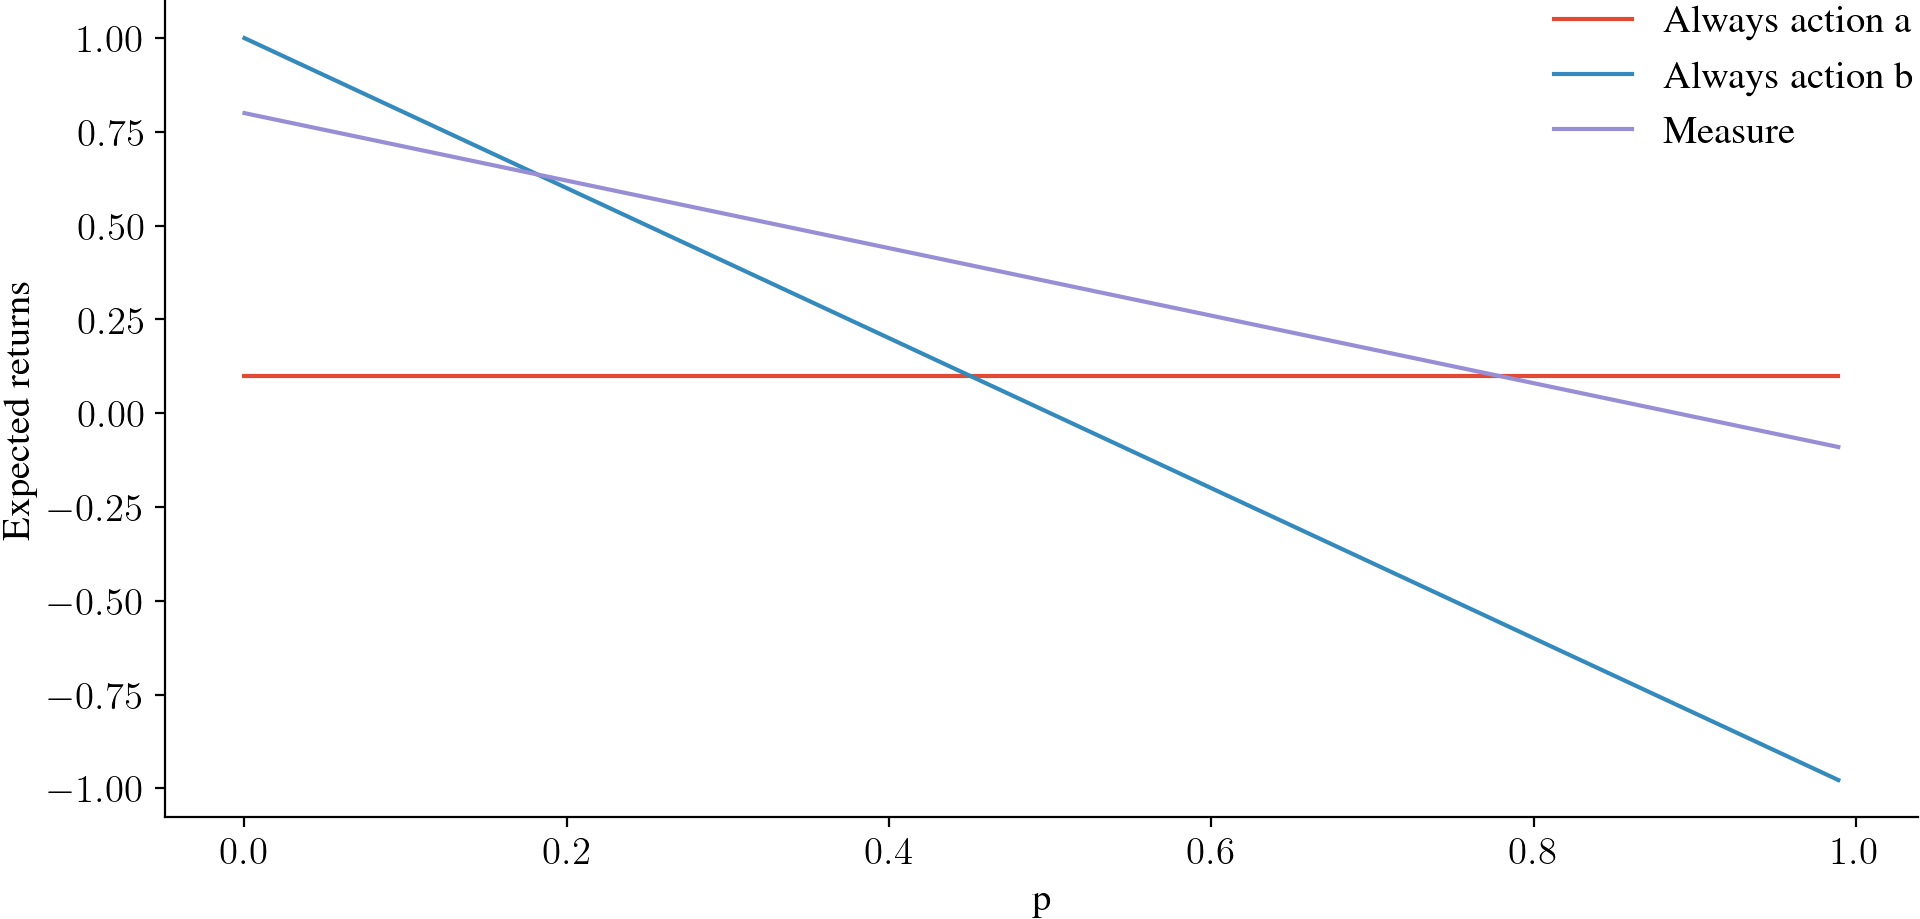

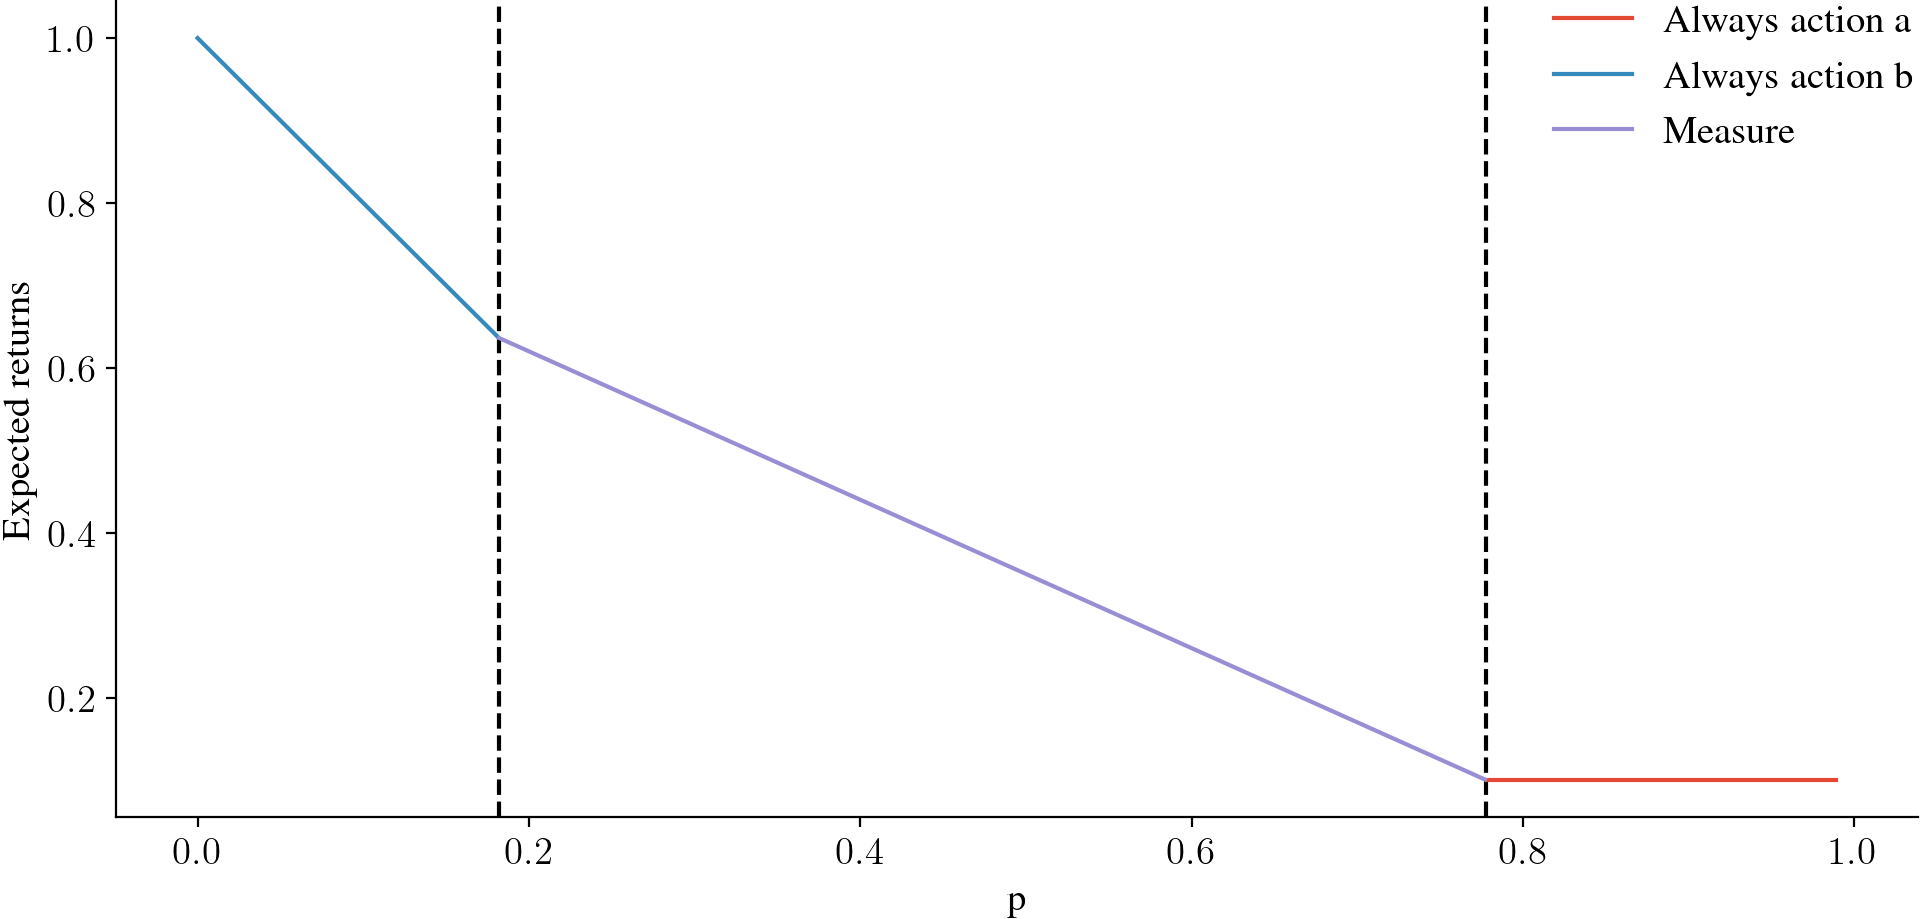

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


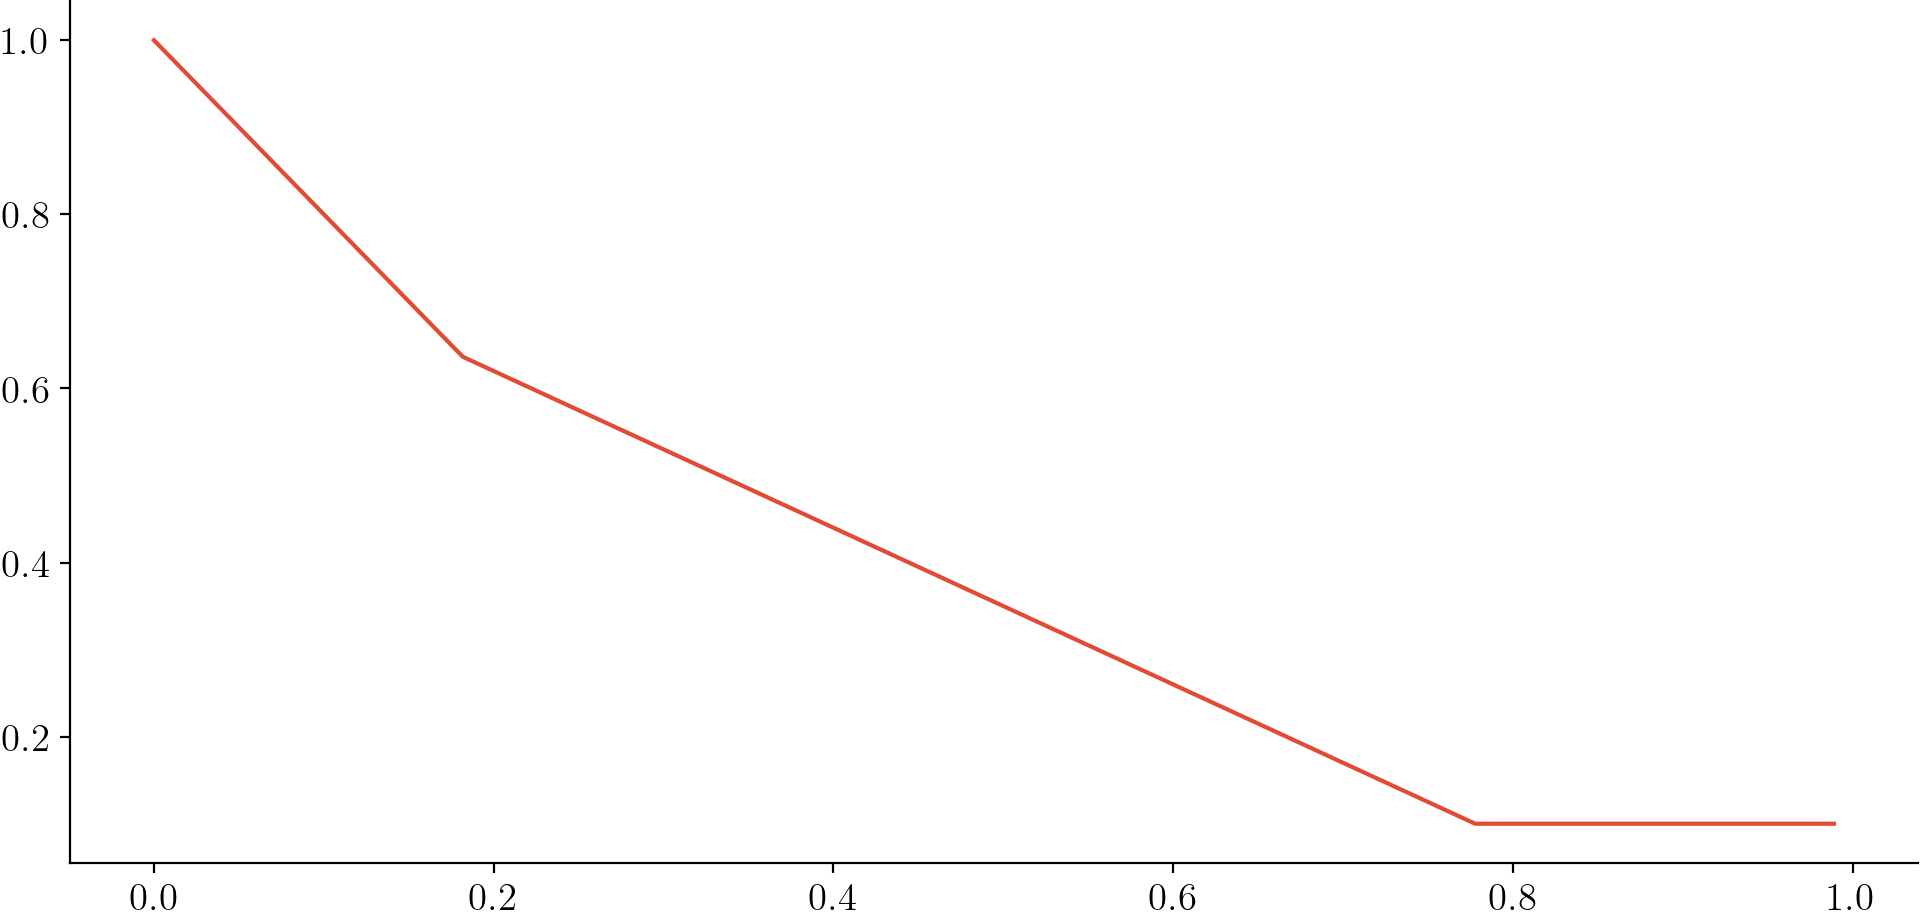

In [31]:
# Plotting optimal returns:

def replace_non_matching(a, aref, value):
    nonmatching = a != aref
    a [nonmatching] = value
    return a

ps = np.arange(start=0, stop=0.99, step=0.001)
c = 0.2
r1 = np.ones_like(ps) * 0.1
r2 = 1 - 2 * ps
r3 = ps*0.1 + (1-ps) - c
# r4 = (c + ps - 1) / (ps - 1)
rmax = np.max([r1, r2, r3], axis=0)
ps_rmax = ps

xaxis = "p"
yaxis = "Expected returns"

legend = ["Always action a", "Always action b", "Measure"]

plot_lines(x=ps, ys=[r1, r2, r3], legend=legend, show=True, xlabel=xaxis, ylabel=yaxis)

r1, r2, r3 = replace_non_matching(r1, rmax, np.nan), replace_non_matching(r2, rmax, np.nan), replace_non_matching(r3, rmax, np.nan)

plt.axvline(x=c/1.1, color='k', linestyle='--')
plt.axvline(x=(1-c/0.9), color='k', linestyle='--')
plot_lines(x=ps, ys=[r1, r2, r3], legend=legend, show=True, xlabel=xaxis, ylabel=yaxis)
plot_lines(x=ps_rmax, ys=[rmax])

#### Same planning, different real

C:\Users\merli\AppData\Local\Temp\ipykernel_2668\2567627454.py:39: RuntimeWarning: invalid value encountered in sqrt
  stds[alg_iter, result_iter, test_iter] = np.std( np.average(rewards) )          / np.sqrt( (plotEpEnd - plotEpStart) * nmbr_runs )


(6, 3, 19) ['ATM (avg)', 'ATM (using RMDP)', 'ATM_Robust', 'ATM_Control_Robust (pes)', 'ATM_Control_Robust (avg)', 'ATM_Control_Robust (opt)']


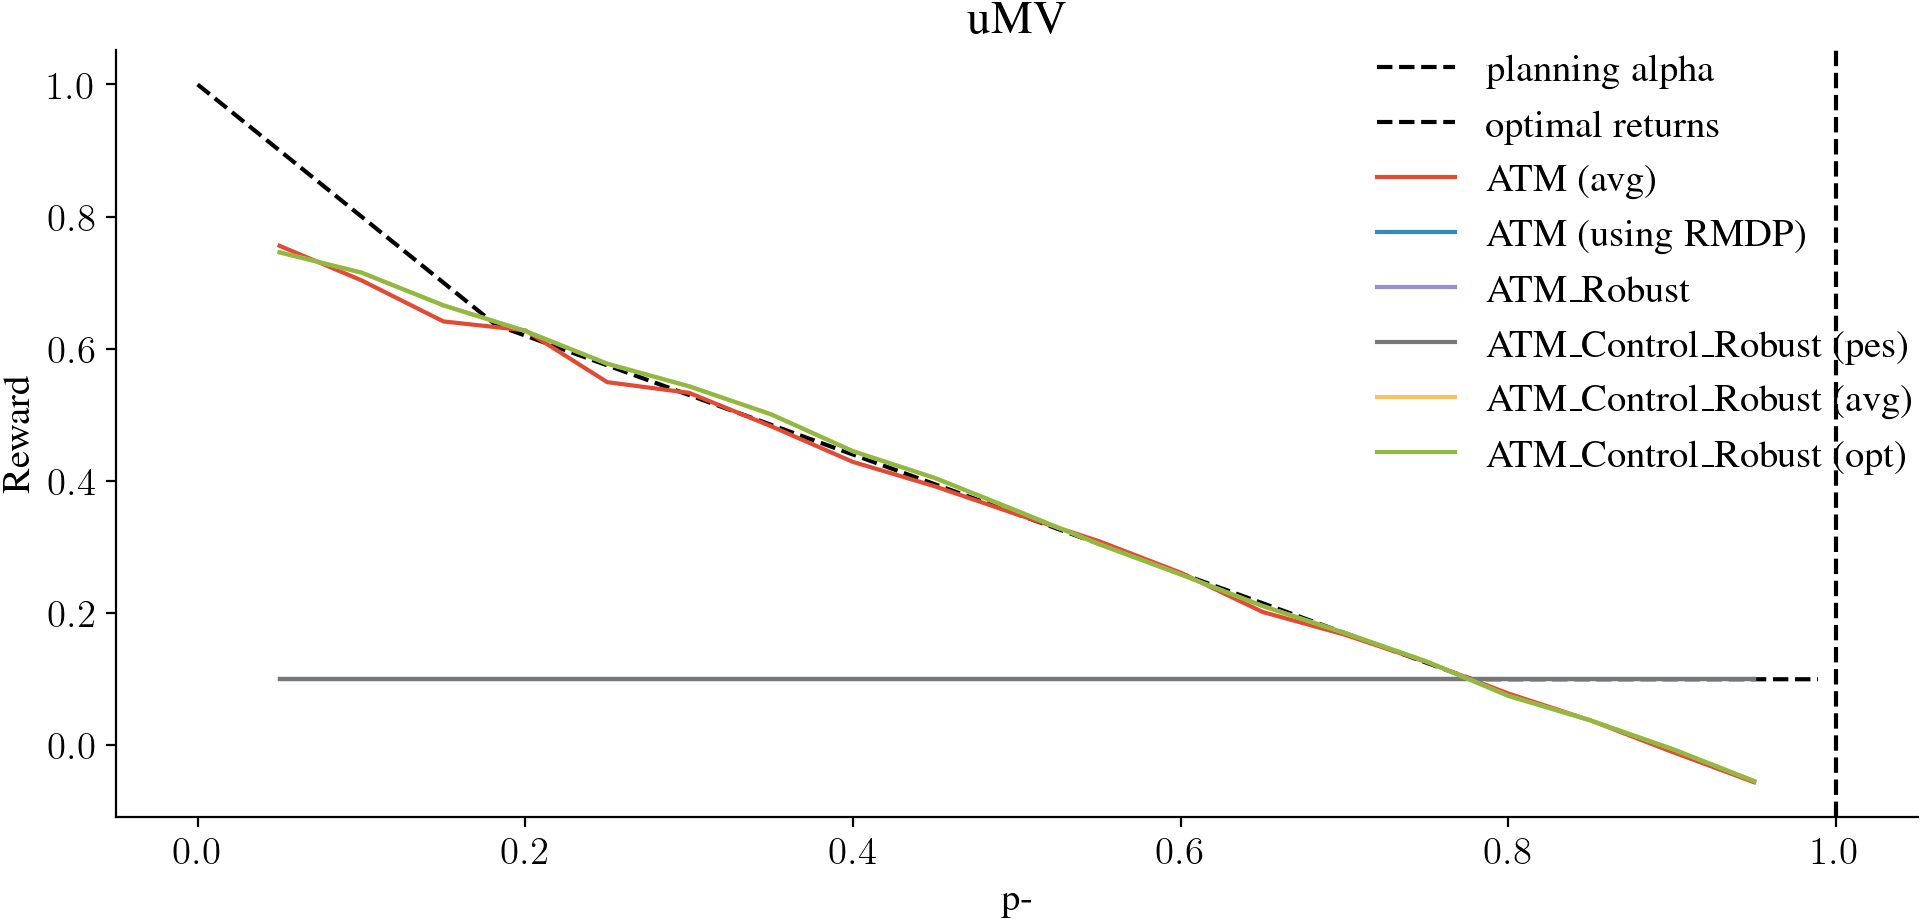

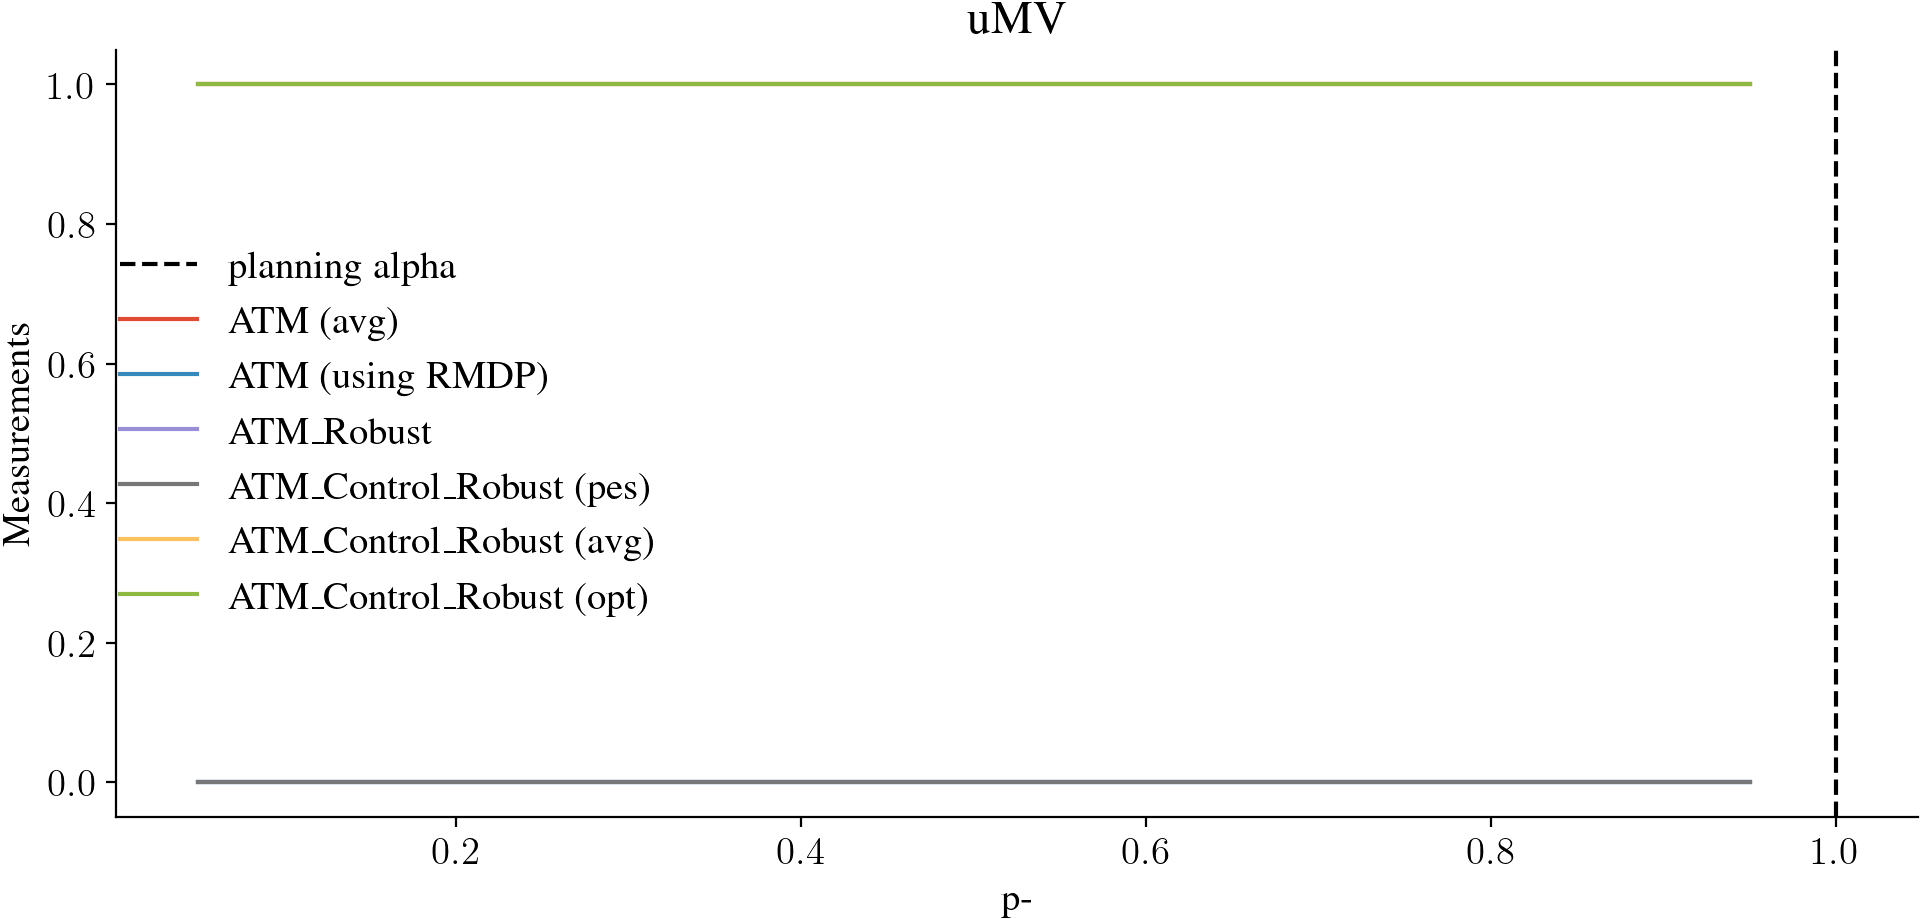

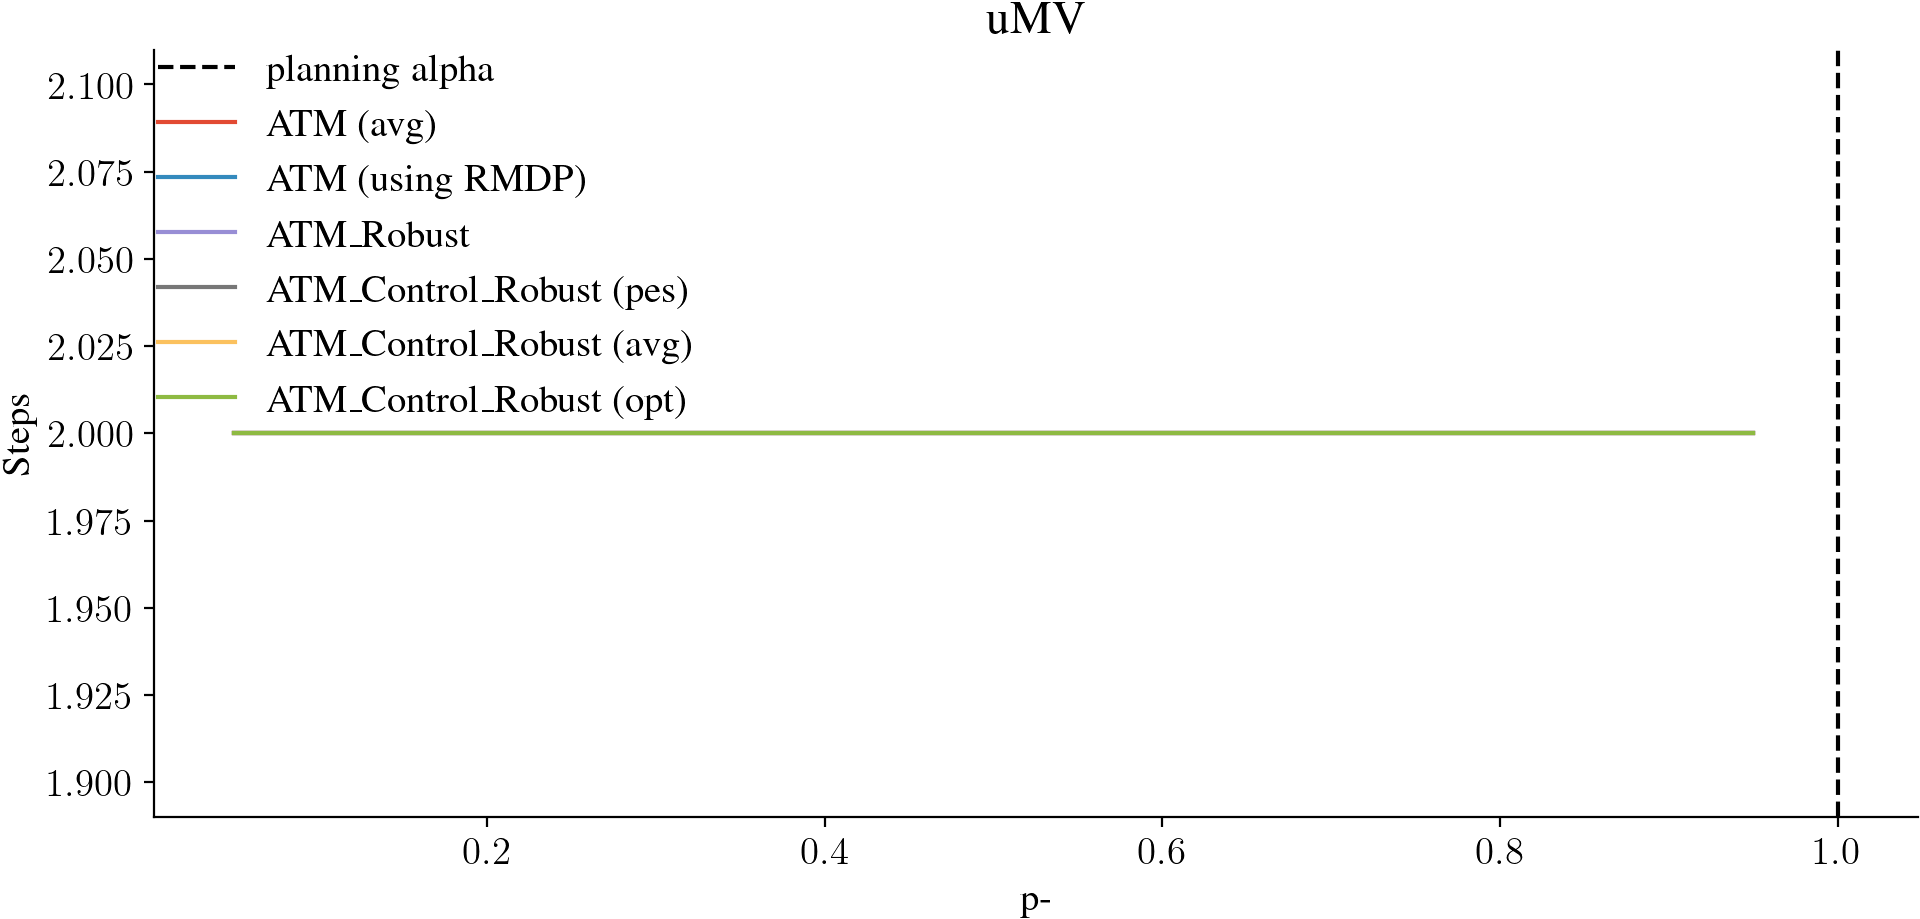

In [32]:
# Regular runs
p_plan = 1
p_plan_set = p_plan / 2
algnames = ["ATM", "ATM_RMDP", "ATM_Robust", "ATM_Control_Robust"]
# algnames = ["ATM", "ATM_Robust", "ATM_Control_Robust"]
# algnames = ["ATM", "ATM_RMDP"]
# algnames = ["ATM_Robust", "ATM_Robust"]
resultvars = ["reward_per_eps", "steps_per_eps", "measurements_per_eps"]
ps = np.arange(start=0.05, stop=1.0, step=0.05)

str1 = "Data/Temp1/AMData_"; str2 = "_uMV_"
str3 = "_r1_pvar{0}_p{1}_mc02.json".format(float_to_str(p_plan_set), float_to_str(0.5))

nmbralgs, nmbrresults, nmbrtests = np.size(algnames), np.size(resultvars), np.size(ps)
nmbr_extra_algs = 2
all_avgs, all_stds = np.ones((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests))
avg_rewards, std_rewards = np.ones((nmbralgs + nmbr_extra_algs, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrtests))
avg_measures, std_measures = np.ones((nmbralgs + nmbr_extra_algs, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrtests))
avg_steps, std_steps = np.ones((nmbralgs + nmbr_extra_algs, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrtests))

all_avgs[:nmbralgs], all_stds[:nmbralgs] = collect_data_from_files(algnames, resultvars, ps, str1, str2, str3, smoothen=False)


# Optimistic and pesimistic Control robustness
algnames = ["ATM_Control_Robust"]
str3 = "_r1_pvar{0}_p{1}_m{2}_mc02.json".format(float_to_str(p_plan_set), float_to_str(0.5), float_to_str(1))
all_avgs[nmbralgs], all_stds[nmbralgs] = collect_data_from_files(algnames, resultvars, ps, str1, str2, str3, smoothen=False)

str3 = "_r1_pvar{0}_p{1}_m{2}_mc02.json".format(float_to_str(p_plan_set), float_to_str(0.5), float_to_str(-0.5))
all_avgs[nmbralgs+1], all_stds[nmbralgs+1] = collect_data_from_files(algnames, resultvars, ps, str1, str2, str3, smoothen=False)



avg_rewards, std_rewards = all_avgs[:,0,:], all_stds[:,0,:]
avg_measures, std_measures = all_avgs[:,2,:], all_stds[:,2,:]
avg_steps, std_steps = all_avgs[:,1,:], all_stds[:,1,:]

legend = ["ATM (avg)", "ATM (using RMDP)", "ATM_Robust", "ATM_Control_Robust (pes)", "ATM_Control_Robust (avg)", "ATM_Control_Robust (opt)"]
# legend = ["ATM (avg)", "ATM_Robust", "ATM_Control_Robust (pes)", "ATM_Control_Robust (avg)", "ATM_Control_Robust (opt)"]
# legend = ["ATM_RMDP", "ATM_RMDP"]
# legend = ["ATM","ATM_Robust", "ATM_Control_Robust (opt)"]
xaxis = "p-"
yaxis_r = "Reward"
yaxis_m = "Measurements"
yaxis_s = "Steps"

print(np.shape(all_avgs), legend)
plt.axvline(x=p_plan, color='k', linestyle='--', label="planning alpha")
plt.plot(ps_rmax, rmax, color='k', linestyle='--', label="optimal returns")
plot_lines(avg_rewards, ps, std_rewards, legend=legend, xlabel=xaxis, ylabel=yaxis_r, title="uMV")
plt.axvline(x=p_plan, color='k', linestyle='--', label="planning alpha")
plot_lines(avg_measures, ps, std_measures, legend=legend, xlabel=xaxis, ylabel=yaxis_m, title="uMV")
plt.axvline(x=p_plan, color='k', linestyle='--', label="planning alpha")
plot_lines(avg_steps, ps, std_steps, legend=legend, xlabel=xaxis, ylabel=yaxis_s, title="uMV")
# Without non-robust ATM
# plot_lines(avg_rewards[1:], alphas, std_rewards[1:], legend=legend[1:])

Data\Temp1\AMData_ATM_Control_Robust_uMV_005_r1_pvar05_p05_m1_mc02.json
Data/Temp1/AMData_ATM_Control_Robust_uMV_005_r1_pvar05_p05_mvar05_m1_mc02.json

#### Measuring Behaviour

C:\Users\merli\AppData\Local\Temp\ipykernel_2668\2567627454.py:39: RuntimeWarning: invalid value encountered in sqrt
  stds[alg_iter, result_iter, test_iter] = np.std( np.average(rewards) )          / np.sqrt( (plotEpEnd - plotEpStart) * nmbr_runs )


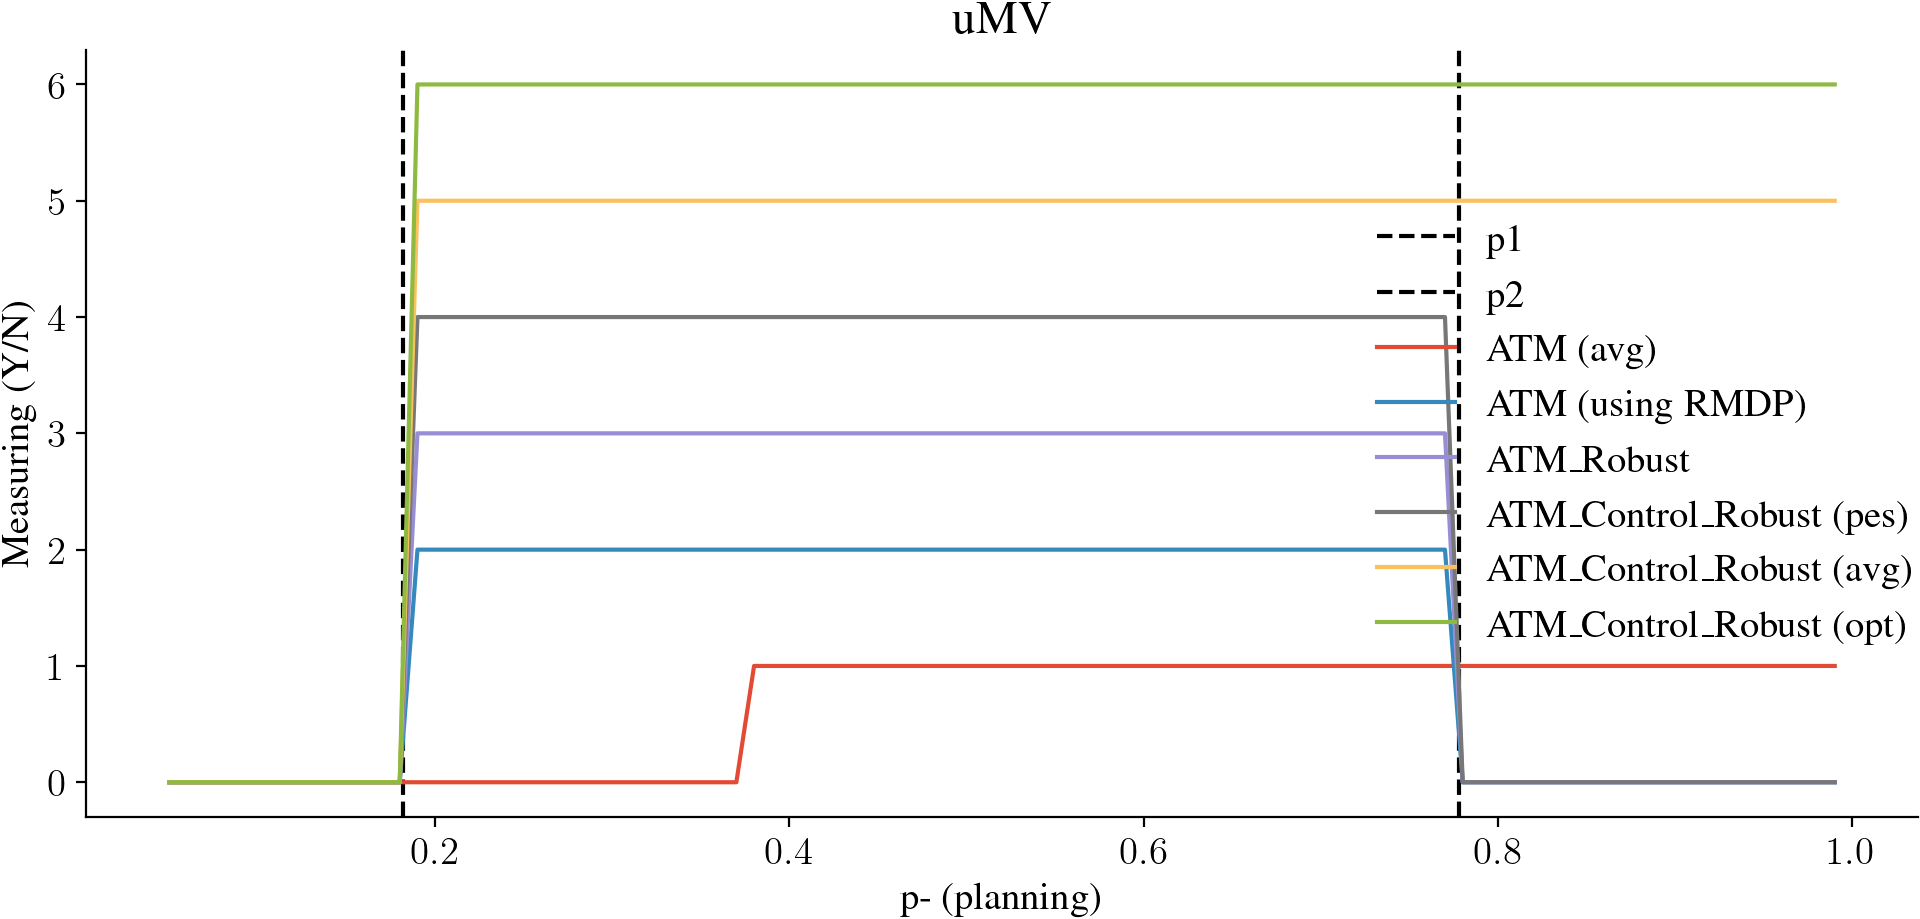

In [35]:
# Testing measuring behaviour

algnames = ["ATM", "ATM_RMDP", "ATM_Robust", "ATM_Control_Robust"]
# algnames = ["ATM", "ATM_Robust", "ATM_Control_Robust"]
# algnames = ["ATM", "ATM_RMDP"]
# algnames = ["ATM_Robust", "ATM_Robust"]
resultvars = ["reward_per_eps", "steps_per_eps", "measurements_per_eps"]
pvars = np.arange(start=0.05, stop=1.0, step=0.01)/2
ps = pvars * 2

str1 = "Data/Temp1/uMV/AMData_"; str2 = "_uMV_05_r1_pvar"
str3 = "_p{0}_mc02.json".format(float_to_str(0.5))

nmbralgs, nmbrresults, nmbrtests = np.size(algnames), np.size(resultvars), np.size(pvars)
nmbr_extra_algs = 2
all_avgs, all_stds = np.ones((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrresults, nmbrtests))
avg_rewards, std_rewards = np.ones((nmbralgs + nmbr_extra_algs, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrtests))
avg_measures, std_measures = np.ones((nmbralgs + nmbr_extra_algs, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrtests))
avg_steps, std_steps = np.ones((nmbralgs + nmbr_extra_algs, nmbrtests)), np.ones((nmbralgs + nmbr_extra_algs, nmbrtests))

all_avgs[:nmbralgs], all_stds[:nmbralgs] = collect_data_from_files(algnames, resultvars, pvars, str1, str2, str3, smoothen=False)


# Optimistic and pesimistic Control robustness
algnames = ["ATM_Control_Robust"]
str3 = "_p{1}_m{2}_mc02.json".format(float_to_str(p_plan_set), float_to_str(0.5), float_to_str(1))
all_avgs[nmbralgs], all_stds[nmbralgs] = collect_data_from_files(algnames, resultvars, pvars, str1, str2, str3, smoothen=False)

str3 = "_p{1}_m{2}_mc02.json".format(float_to_str(p_plan_set), float_to_str(0.5), float_to_str(-0.5))
all_avgs[nmbralgs+1], all_stds[nmbralgs+1] = collect_data_from_files(algnames, resultvars, pvars, str1, str2, str3, smoothen=False)

avg_measures, std_measures = all_avgs[:,2,:], all_stds[:,2,:]
for i in range(nmbr_algs+nmbr_extra_algs):
    avg_measures[i], std_measures[i] = avg_measures[i]*(i+1), std_measures[i]*(i+1)



legend = ["ATM (avg)", "ATM (using RMDP)", "ATM_Robust", "ATM_Control_Robust (pes)", "ATM_Control_Robust (avg)", "ATM_Control_Robust (opt)"]
xaxis = "p- (planning)"
yaxis_m = "Measuring (Y/N)"

plt.axvline(x=c/1.1, color='k', linestyle='--', label="p1")
plt.axvline(x=(1-c/0.9), color='k', linestyle='--', label="p2")
plot_lines(avg_measures, ps, std_measures, legend=legend, xlabel=xaxis, ylabel=yaxis_m, title="uMV")
